# Do interface design to further filter out unproductive designs prior to looping

### Boilerplate

In [1]:
%load_ext lab_black
# python internal
import collections
import copy
import gc
from glob import glob
import h5py
import itertools
import os
import random
import re
import socket
import shutil
import subprocess
import sys

# conda/pip
import dask
import graphviz
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
from tqdm import tqdm

# special packages on the DIGS
import py3Dmol
import pymol
import pyrosetta

# notebook magic
%matplotlib inline
%load_ext autoreload
%autoreload 2

print(os.getcwd())
print(socket.gethostname())

/mnt/home/pleung/projects/bistable_bundle/r4/helix_binders
dig120


### Original approach for design and filtering docked helix binders
2) design of states was done in `/home/flop/switch/5thround/DHRs/allo3/des1/ and des2` (xmls)  
3) extended the helix using `/home/flop/switch/5thround/DHRs/allo3/ext_hlx/extend_hlx.ipynb`  
I'll scale up the approach and collect additional metadata using `PyRosetta.distributed`  
In this round, will skip extending the helix

### Make functions for design and scoring
TRP is allowed again

In [2]:
from pyrosetta.distributed.packed_pose.core import PackedPose
from pyrosetta.distributed import requires_init
from typing import *


@requires_init
def design_score(packed_pose_in: PackedPose, **kwargs) -> PackedPose:
    """Returns PackedPose objects, does 2rds. of fixbb design followed by 3rds. of flexbb design, followed by scoring."""
    import bz2
    import pyrosetta
    import pyrosetta.distributed.io as io
    from pyrosetta.distributed.tasks.rosetta_scripts import (
        SingleoutputRosettaScriptsTask,
    )

    if packed_pose_in == None:
        file = kwargs["-s"]
        with open(file, "rb") as f:
            ppose = io.pose_from_pdbstring(bz2.decompress(f.read()).decode())
        scores = pyrosetta.distributed.cluster.get_scores_dict(file)["scores"]
    else:
        ppose = packed_pose_in
        scores = dict(packed_pose_in.pose.scores)
    xml = """
    <ROSETTASCRIPTS>
        <SCOREFXNS>
            <ScoreFunction name="sfxn" weights="beta_nov16" /> 
            <ScoreFunction name="sfxn_design" weights="beta_nov16" >
                <Reweight scoretype="res_type_constraint" weight="1.0" />
            </ScoreFunction>
        </SCOREFXNS>
        <RESIDUE_SELECTORS>
            <Chain name="chA" chains="A"/>
            <Chain name="chB" chains="B"/>
            <Chain name="chC" chains="C"/>
            <Neighborhood name="neighbors_chA" selector="chA" distance="8.0" />
            <Neighborhood name="neighbors_chB" selector="chB" distance="8.0" />
            <Neighborhood name="neighbors_chC" selector="chC" distance="8.0" />
            <And name="interface_AB" selectors="neighbors_chA,neighbors_chB" />
            <And name="interface_AC" selectors="neighbors_chA,neighbors_chC" />
            <And name="interface_BC" selectors="neighbors_chB,neighbors_chC" />
            <ResidueName name="pro_and_gly_positions" residue_name3="PRO,GLY" />
            <Or name="designable" selectors="interface_AB,interface_AC,interface_BC" />
            <Not name="not_designable" selector="designable" />
            <Layer name="surface" select_core="false" select_boundary="false" select_surface="true"
                use_sidechain_neighbors="true"/>
            <Layer name="boundary" select_core="false" select_boundary="true" select_surface="false" 
                use_sidechain_neighbors="true"/>
            <Layer name="core" select_core="true" select_boundary="false" select_surface="false" 
                use_sidechain_neighbors="true"/>
            <SecondaryStructure name="sheet" overlap="0" minH="3" minE="2" include_terminal_loops="false" 
                use_dssp="true" ss="E"/>
            <SecondaryStructure name="entire_loop" overlap="0" minH="3" minE="2" include_terminal_loops="true" 
                use_dssp="true" ss="L"/>
            <SecondaryStructure name="entire_helix" overlap="0" minH="3" minE="2" include_terminal_loops="false"
                use_dssp="true" ss="H"/>
            <And name="helix_cap" selectors="entire_loop">
                <PrimarySequenceNeighborhood lower="1" upper="0" selector="entire_helix"/>
            </And>
            <And name="helix_start" selectors="entire_helix">
                <PrimarySequenceNeighborhood lower="0" upper="1" selector="helix_cap"/>
            </And>
            <And name="helix" selectors="entire_helix">
                <Not selector="helix_start"/>
            </And>
            <And name="loop" selectors="entire_loop">
                <Not selector="helix_cap"/>
            </And>
        </RESIDUE_SELECTORS>
        <TASKOPERATIONS>
            <DesignRestrictions name="layer_design">
                <Action selector_logic="surface AND helix_start"  aas="DEHKPQR"/>
                <Action selector_logic="surface AND helix"        aas="EHKQR"/>
                <Action selector_logic="surface AND sheet"        aas="EHKNQRST"/>
                <Action selector_logic="surface AND loop"         aas="DEGHKNPQRST"/>
                <Action selector_logic="boundary AND helix_start" aas="ADEHIKLNPQRSTVWY"/>
                <Action selector_logic="boundary AND helix"       aas="ADEHIKLNQRSTVWYM"/>
                <Action selector_logic="boundary AND sheet"       aas="DEFHIKLNQRSTVWY"/>
                <Action selector_logic="boundary AND loop"        aas="ADEFGHIKLNPQRSTVWY"/>
                <Action selector_logic="core AND helix_start"     aas="AFILVWYNQSTHP"/>
                <Action selector_logic="core AND helix"           aas="AFILVWM"/>
                <Action selector_logic="core AND sheet"           aas="FILVWY"/>
                <Action selector_logic="core AND loop"            aas="AFGILPVWYSM"/>
                <Action selector_logic="helix_cap"                aas="DNSTP"/>
            </DesignRestrictions>
            <PruneBuriedUnsats name="prune" allow_even_trades="false" 
                atomic_depth_cutoff="3.5" minimum_hbond_energy="-1.0"/>
            <ProteinProteinInterfaceUpweighter name="upweight_int" interface_weight="3" />
            <LimitAromaChi2 name="arochi" chi2max="110" chi2min="70" include_trp="True" />
            <ExtraRotamersGeneric name="ex1_ex2" ex1="1" ex2="1" />
            <OperateOnResidueSubset name="int_only" selector="not_designable">
                <PreventRepackingRLT/>
            </OperateOnResidueSubset>
            <OperateOnResidueSubset name="restrict_PRO_GLY" selector="pro_and_gly_positions">
                <PreventRepackingRLT/>
            </OperateOnResidueSubset>
        </TASKOPERATIONS>
        <FILTERS>
        </FILTERS>
        <MOVERS>
            <StructProfileMover name="gen_profile" add_csts_to_pose="1" consider_topN_frags="100" 
                eliminate_background="0" ignore_terminal_residue="1" only_loops="0"
                residue_selector="designable" burialWt="0" RMSthreshold="0.6" />
            <ClearConstraintsMover name="clear_constraints" />
            <FastDesign name="fixbb_with_jump" scorefxn="sfxn_design" repeats="1" 
                task_operations="arochi,ex1_ex2,upweight_int,restrict_PRO_GLY,layer_design,prune,int_only" 
                batch="false" ramp_down_constraints="false" cartesian="false" bondangle="false" 
                bondlength="false" min_type="dfpmin_armijo_nonmonotone" relaxscript="InterfaceDesign2019" >
                <MoveMap name="MM" >
                    <Chain number="1" chi="true" bb="false" />
                    <Chain number="2" chi="true" bb="false" />
                    <Chain number="3" chi="true" bb="false" />
                    <Jump number="1" setting="true" />
                    <Jump number="2" setting="true" />
                </MoveMap>
            </FastDesign>
            <FastDesign name="flexbb_with_jump" scorefxn="sfxn_design" repeats="2"
                task_operations="arochi,ex1_ex2,upweight_int,restrict_PRO_GLY,layer_design,prune,int_only" 
                batch="false" ramp_down_constraints="false" cartesian="false" bondangle="false" 
                bondlength="false" min_type="dfpmin_armijo_nonmonotone" relaxscript="InterfaceDesign2019" >
                <MoveMap name="MM" >
                    <Chain number="1" chi="true" bb="true" />
                    <Chain number="2" chi="true" bb="true" />
                    <Chain number="3" chi="true" bb="true" />
                    <Jump number="1" setting="true" />
                    <Jump number="2" setting="true" />
                </MoveMap>
            </FastDesign>
            <SwitchChainOrder name="cutC" chain_order="12" />
            <SwitchChainOrder name="cutB" chain_order="13" />
            <SwitchChainOrder name="cutA" chain_order="23" />
            <ScoreMover name="scorepose" scorefxn="sfxn" verbose="false" />
        </MOVERS>
        <FILTERS>
            <Sasa name="interface_buried_sasa" confidence="0" />
            <SSShapeComplementarity name="sc" verbose="1" loops="1" helices="1" />
            <ShapeComplementarity name="sc_int" verbose="0" min_sc="0.55" write_int_area="1" write_median_dist="1" jump="1" confidence="0"/>
            <TaskAwareScoreType name="tot_score" scorefxn="sfxn" score_type="total_score" threshold="0" mode="total"  confidence="0" />
            <MoveBeforeFilter name="sasa_AB" mover="cutC" filter="interface_buried_sasa" confidence="0"/>
            <MoveBeforeFilter name="sasa_AC" mover="cutB" filter="interface_buried_sasa" confidence="0"/>
            <MoveBeforeFilter name="sasa_BC" mover="cutA" filter="interface_buried_sasa" confidence="0"/>
            <MoveBeforeFilter name="score_AB" mover="cutC" filter="tot_score" confidence="0"/>
            <MoveBeforeFilter name="score_AC" mover="cutB" filter="tot_score" confidence="0"/>
            <MoveBeforeFilter name="score_BC" mover="cutA" filter="tot_score" confidence="0"/>
            <ScoreType name="total_score_pose" scorefxn="sfxn" score_type="total_score" threshold="0" confidence="0" />
            <ResidueCount name="count" />
            <CalculatorFilter name="score_per_res" equation="total_score_full / res" threshold="-2.0" confidence="0">
                <Var name="total_score_full" filter="total_score_pose"/>
                <Var name="res" filter="count"/>
            </CalculatorFilter>
        </FILTERS>
        <APPLY_TO_POSE>
        </APPLY_TO_POSE>
        <PROTOCOLS>
            <Add mover="gen_profile" />
            <Add mover="fixbb_with_jump" />
            <Add mover="flexbb_with_jump" />
            <Add mover="clear_constraints" />
            <Add filter_name="interface_buried_sasa" />
            <Add filter_name="sasa_AB" />
            <Add filter_name="sasa_AC" />
            <Add filter_name="sasa_BC" />
            <Add filter_name="sc" />
            <Add filter_name="sc_int" />
            <Add filter_name="score_AB"/>
            <Add filter_name="score_AC"/>
            <Add filter_name="score_BC"/>
            <Add filter_name="score_per_res" />
        </PROTOCOLS>
    </ROSETTASCRIPTS>
    """
    design_score = SingleoutputRosettaScriptsTask(xml)
    designed_ppose = design_score(ppose.pose.clone())
    pose = io.to_pose(designed_ppose)
    scores.update(dict(pose.scores))
    print(scores)
    for key, value in scores.items():
        pyrosetta.rosetta.core.pose.setPoseExtraScore(
            pose, key, str(value)
        )  # store values as strings for safety
    designed_ppose = io.to_packed(pose)
    return designed_ppose

### Setup dask, set command line options, make tasks and submit to client
At some point I should try using `client.wait_for_workers(n_workers=1, timeout=None)`

In [4]:
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
import logging
import pwd
from pyrosetta.distributed.cluster.core import PyRosettaCluster


print("run the following from your local terminal:")
print(
    f"ssh -L 8000:localhost:8787 {pwd.getpwuid(os.getuid()).pw_name}@{socket.gethostname()}"
)


def create_tasks(selected, options):
    with open(selected, "r") as f:
        for file in f:
            tasks = {"options": "-corrections::beta_nov16 true"}
            tasks["extra_options"] = options
            tasks["-s"] = file.rstrip()
            yield tasks


logging.basicConfig(level=logging.INFO)
selected = os.path.join(os.getcwd(), "01_make_states/selected_states.list")

options = {
    "-out:level": "300",
    "-holes:dalphaball": "/home/bcov/ppi/tutorial_build/main/source/external/DAlpahBall/DAlphaBall.gcc",
    "-indexed_structure_store:fragment_store": "/home/bcov/sc/scaffold_comparison/data/ss_grouped_vall_all.h5",
}

output_path = os.path.join(os.getcwd(), "02_design_score")

if __name__ == "__main__":
    # configure SLURM cluster as a context manager
    with SLURMCluster(
        cores=1,
        processes=1,
        job_cpu=1,
        memory="8GB",
        queue="medium",
        walltime="23:30:00",
        death_timeout=120,
        local_directory="$TMPDIR/dask",
        log_directory="/mnt/home/pleung/logs/slurm_logs",
        extra=["--lifetime", "23h", "--lifetime-stagger", "4m"],
    ) as cluster:
        print(cluster.job_script())
        # scale between 1-1020 workers,
        cluster.adapt(
            minimum=1,
            maximum=1020,
            wait_count=999,  # Number of consecutive times that a worker should be suggested for removal it is removed
            interval="5s",  # Time between checks
        )
        # setup a client to interact with the cluster as a context manager
        with Client(cluster) as client:
            print(client)
            PyRosettaCluster(
                tasks=create_tasks(selected, options),
                client=client,
                scratch_dir=output_path,
                output_path=output_path,
                nstruct=5,
            ).distribute(protocols=[design_score])

run the following from your local terminal:
ssh -L 8000:localhost:8787 pleung@dig120
#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -e /mnt/home/pleung/logs/slurm_logs/dask-worker-%J.err
#SBATCH -o /mnt/home/pleung/logs/slurm_logs/dask-worker-%J.out
#SBATCH -p medium
#SBATCH -n 1
#SBATCH --cpus-per-task=1
#SBATCH --mem=8G
#SBATCH -t 23:30:00

JOB_ID=${SLURM_JOB_ID%;*}

/home/pleung/.conda/envs/phil/bin/python -m distributed.cli.dask_worker tcp://172.16.131.224:34195 --nthreads 1 --memory-limit 7.45GiB --name name --nanny --death-timeout 120 --local-directory $TMPDIR/dask --lifetime 23h --lifetime-stagger 4m

<Client: 'tcp://172.16.131.224:34195' processes=0 threads=0, memory=0 B>


INFO:pyrosetta.distributed:maybe_init performing pyrosetta initialization: {'options': '-run:constant_seed 1 -multithreading:total_threads 1', 'extra_options': '-mute all', 'set_logging_handler': 'interactive', 'silent': True}
INFO:pyrosetta.rosetta:Found rosetta database at: /home/pleung/.conda/envs/phil/lib/python3.8/site-packages/pyrosetta/database; using it....
INFO:pyrosetta.rosetta:PyRosetta-4 2021 [Rosetta PyRosetta4.conda.linux.cxx11thread.serialization.CentOS.python38.Release 2021.12+release.ed6a5560506cfd327d4a6a3e2c9b0c9f6f4a6535 2021-03-26T16:09:25] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.


### Look at scores
Hacky function to load JSON-like data

In [5]:
def read_scorefile(scores):
    import pandas as pd

    scores = pd.read_json(scores, orient="records", typ="frame", lines=True)
    scores = scores.T
    mat = scores.values
    n = mat.shape[0]
    dicts = list(mat[range(n), range(n)])
    index = scores.index
    tabulated_scores = pd.DataFrame(dicts, index=index)
    return tabulated_scores


output_path = os.path.join(os.getcwd(), "02_design_score")
scores = os.path.join(output_path, "scores.json")
scores_df = read_scorefile(scores)
scores_df.head()

bb_clash  \
/mnt/home/pleung/projects/bistable_bundle/r4/he...  15087.8271484375   
/mnt/home/pleung/projects/bistable_bundle/r4/he...  15087.8271484375   
/mnt/home/pleung/projects/bistable_bundle/r4/he...    19331.98828125   
/mnt/home/pleung/projects/bistable_bundle/r4/he...   17312.751953125   
/mnt/home/pleung/projects/bistable_bundle/r4/he...    19331.98828125   

                                                   docked_helix  \
/mnt/home/pleung/projects/bistable_bundle/r4/he...            5   
/mnt/home/pleung/projects/bistable_bundle/r4/he...            5   
/mnt/home/pleung/projects/bistable_bundle/r4/he...            3   
/mnt/home/pleung/projects/bistable_bundle/r4/he...            3   
/mnt/home/pleung/projects/bistable_bundle/r4/he...            3   

                                                    interface_buried_sasa  \
/mnt/home/pleung/projects/bistable_bundle/r4/he...               0.000000   
/mnt/home/pleung/projects/bistable_bundle/r4/he...               0.000000   
/mnt/home/pleung/projects/bistable_bundle/r4/he...               0.000000   
/mnt/home/pleung/projects/bistable_bundle/r4/he...               0.000000   
/mnt/home/pleung/projects/bistable_bundle/r4/he...             614.713379   

                                                         parent parent_length  \
/mnt/home/pleung/projects/bistable_bundle/r4/he...  KH_R4_PXX13           172   
/mnt/home/pleung/projects/bistable_bundle/r4/he...  KH_R4_PXX13           172   
/mnt/home/pleung/projects/bistable_bundle/r4/he...  KH_R4_PXX13           172   
/mnt/home/pleung/projects/bistable_bundle/r4/he...        DHR08           180   
/mnt/home/pleung/projects/bistable_bundle/r4/he...  KH_R4_PXX13           172   

                                                   pivot_helix  \
/mnt/home/pleung/projects/bistable_bundle/r4/he...           4   
/mnt/home/pleung/projects/bistable_bundle/r4/he...           4   
/mnt/home/pleung/projects/bistable_bundle/r4/he...           4   
/mnt/home/pleung/projects/bistable_bundle/r4/he...           4   
/mnt/home/pleung/projects/bistable_bundle/r4/he...           4   

                                                   pre_break_helix  \
/mnt/home/pleung/projects/bistable_bundle/r4/he...               4   
/mnt/home/pleung/projects/bistable_bundle/r4/he...               4   
/mnt/home/pleung/projects/bistable_bundle/r4/he...               4   
/mnt/home/pleung/projects/bistable_bundle/r4/he...               4   
/mnt/home/pleung/projects/bistable_bundle/r4/he...               4   

                                                       sasa_AB     sasa_AC  \
/mnt/home/pleung/projects/bistable_bundle/r4/he...    0.000000  800.017822   
/mnt/home/pleung/projects/bistable_bundle/r4/he...    0.000000  873.711975   
/mnt/home/pleung/projects/bistable_bundle/r4/he...    0.000000  876.528870   
/mnt/home/pleung/projects/bistable_bundle/r4/he...    0.000000    0.000000   
/mnt/home/pleung/projects/bistable_bundle/r4/he...  484.774139  966.793945   

                                                       sasa_BC        sc  \
/mnt/home/pleung/projects/bistable_bundle/r4/he...    0.000000  0.731049   
/mnt/home/pleung/projects/bistable_bundle/r4/he...    0.000000  0.726393   
/mnt/home/pleung/projects/bistable_bundle/r4/he...    0.000000  0.697737   
/mnt/home/pleung/projects/bistable_bundle/r4/he...    0.000000  0.729675   
/mnt/home/pleung/projects/bistable_bundle/r4/he...  184.213928  0.712710   

                                                      sc_int    score_AB  \
/mnt/home/pleung/projects/bistable_bundle/r4/he... -1.000000 -217.515045   
/mnt/home/pleung/projects/bistable_bundle/r4/he... -1.000000 -222.247101   
/mnt/home/pleung/projects/bistable_bundle/r4/he... -1.000000 -171.546967   
/mnt/home/pleung/projects/bistable_bundle/r4/he... -1.000000 -263.910156   
/mnt/home/pleung/projects/bistable_bundle/r4/he...  0.545704 -196.004837   

                                                      score_AC    score_B

In [6]:
len(scores_df)

7045

### Add additional metrics
For example, we need a term that quantifies how big the SASA difference is between the N-terminal half - bound helix interface and C-terminal half - bound helix interface

In [18]:
def parent2scaffold(row):
    parent = row["parent"]
    if "THR" in parent:
        scaffold = "THR"
    elif "TH_DHR" in parent:
        scaffold = "TH_DHR"
    elif "KH_" in parent:
        scaffold = "KH_DHR"
    elif "hDHR" in parent:
        scaffold = "hDHR"
    elif "DHR" in parent:
        scaffold = "DHR"
    else:
        raise RuntimeError
    return scaffold


# abs of difference of sasa
scores_df["sasa_diff_AC_BC"] = np.abs(scores_df["sasa_AC"] - scores_df["sasa_BC"])

scores_df["scaffold"] = scores_df.apply(parent2scaffold, axis=1)
scores_df.groupby(["scaffold"]).mean()

interface_buried_sasa      sasa_AB      sasa_AC      sasa_BC  \
scaffold                                                                 
DHR                 2564.029192  1675.690927  1138.077917  1108.473702   
KH_DHR              2473.345077  1648.421569  1067.145903  1034.081348   
THR                 3030.347318  1879.632810  1236.607940  1379.748084   
TH_DHR              3145.964228  2101.767511  1298.662826  1312.648107   
hDHR                2564.252396  1706.639014  1091.819538  1077.811412   

                sc    sc_int    score_AB    score_AC    score_BC  \
scaffold                                                           
DHR       0.732971  0.750930 -317.130634 -152.983862 -161.225432   
KH_DHR    0.733909  0.728555 -300.874524 -149.027232 -146.753448   
THR       0.705691  0.730986 -605.787483 -297.921114 -308.153861   
TH_DHR    0.735669  0.747434 -392.797239 -187.629040 -194.173244   
hDHR      0.723433  0.754184 -324.453794 -153.405473 -163.550501   

          score_per_res  sasa_diff_AC_BC  sasa_diff_AC_BC_nlog  
scaffold                                                        
DHR           -2.791598       672.556825            672.556825  
KH_DHR        -2.700628       712.654862            712.654862  
THR           -2.857731       979.359824            979.359824  
TH_DHR        -2.872965       831.104942            831.104942  
hDHR          -2.836392       672.266582            672.266582

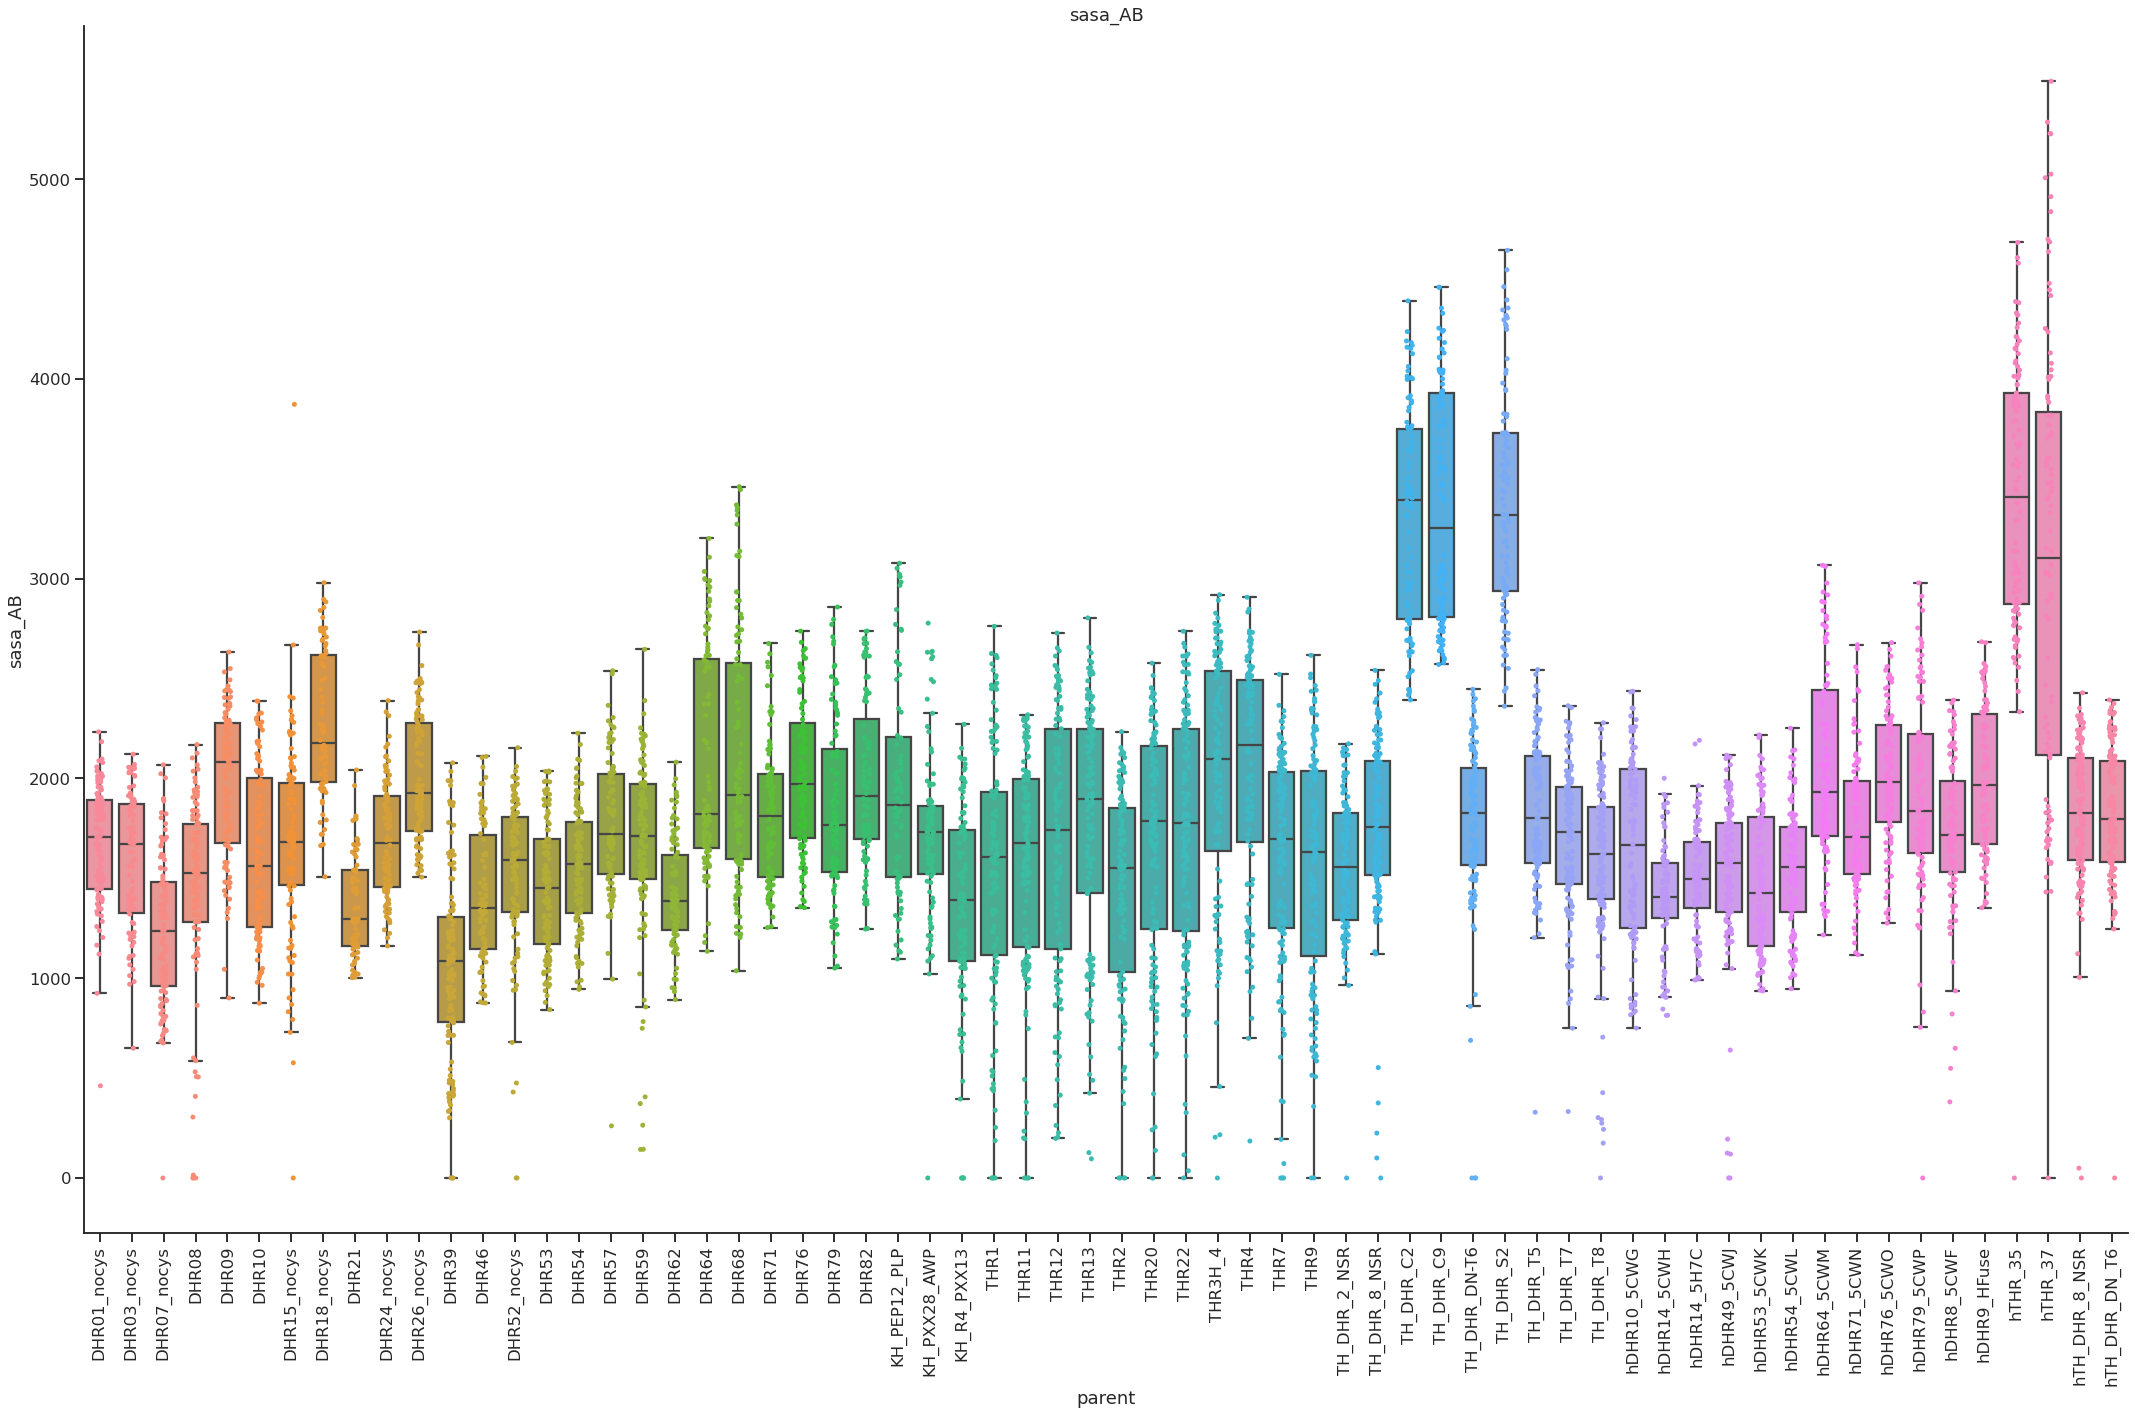

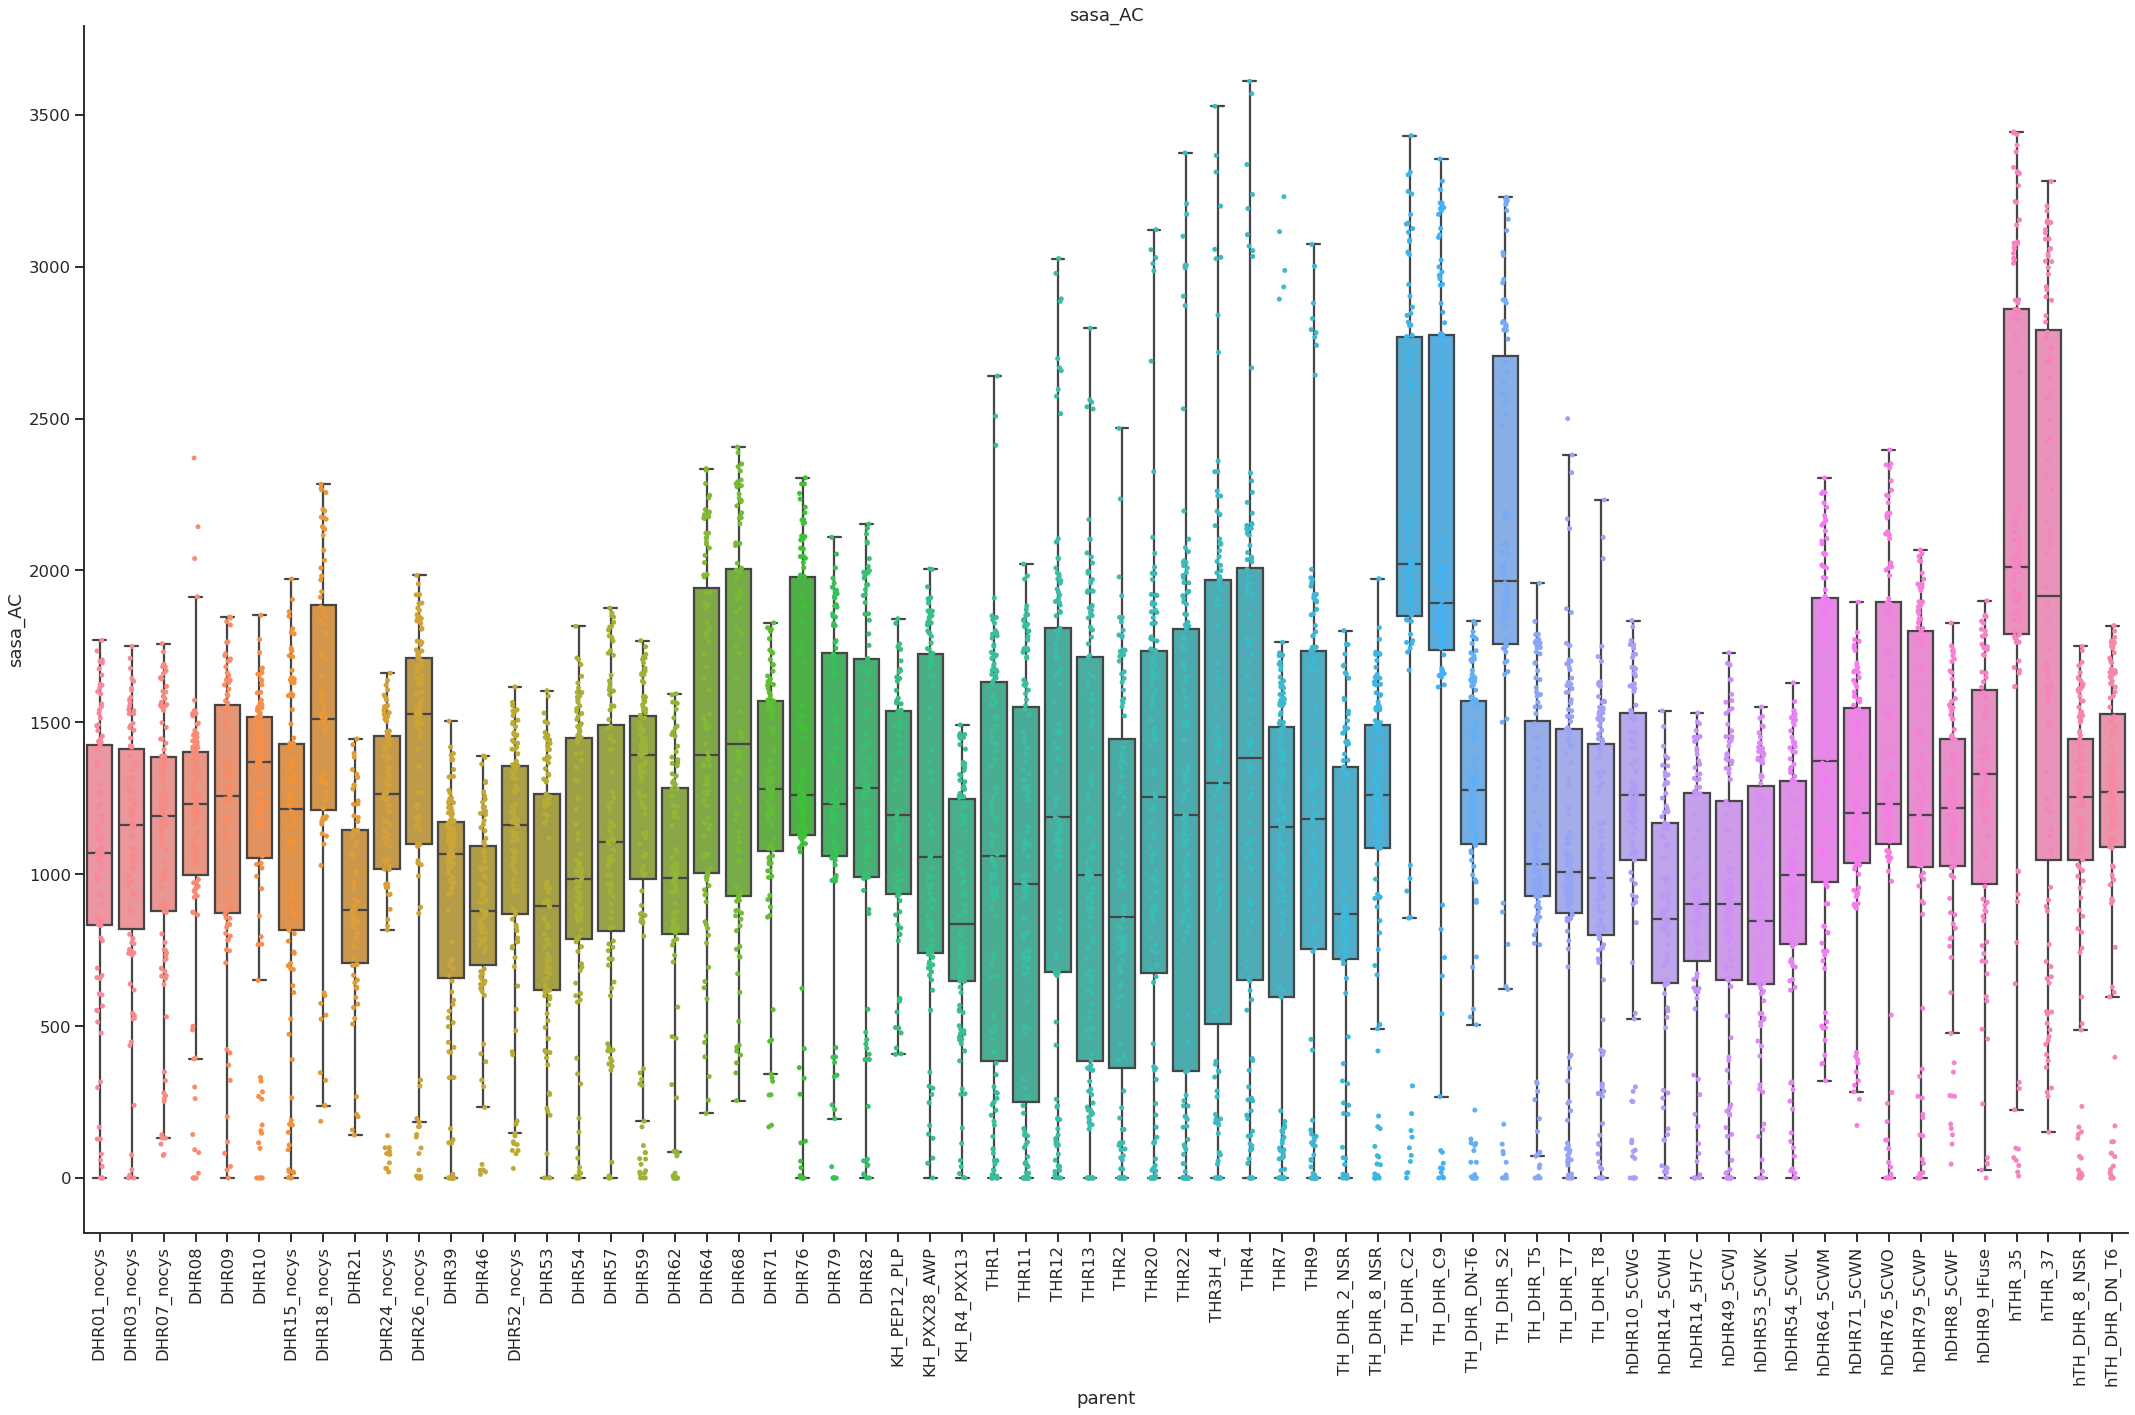

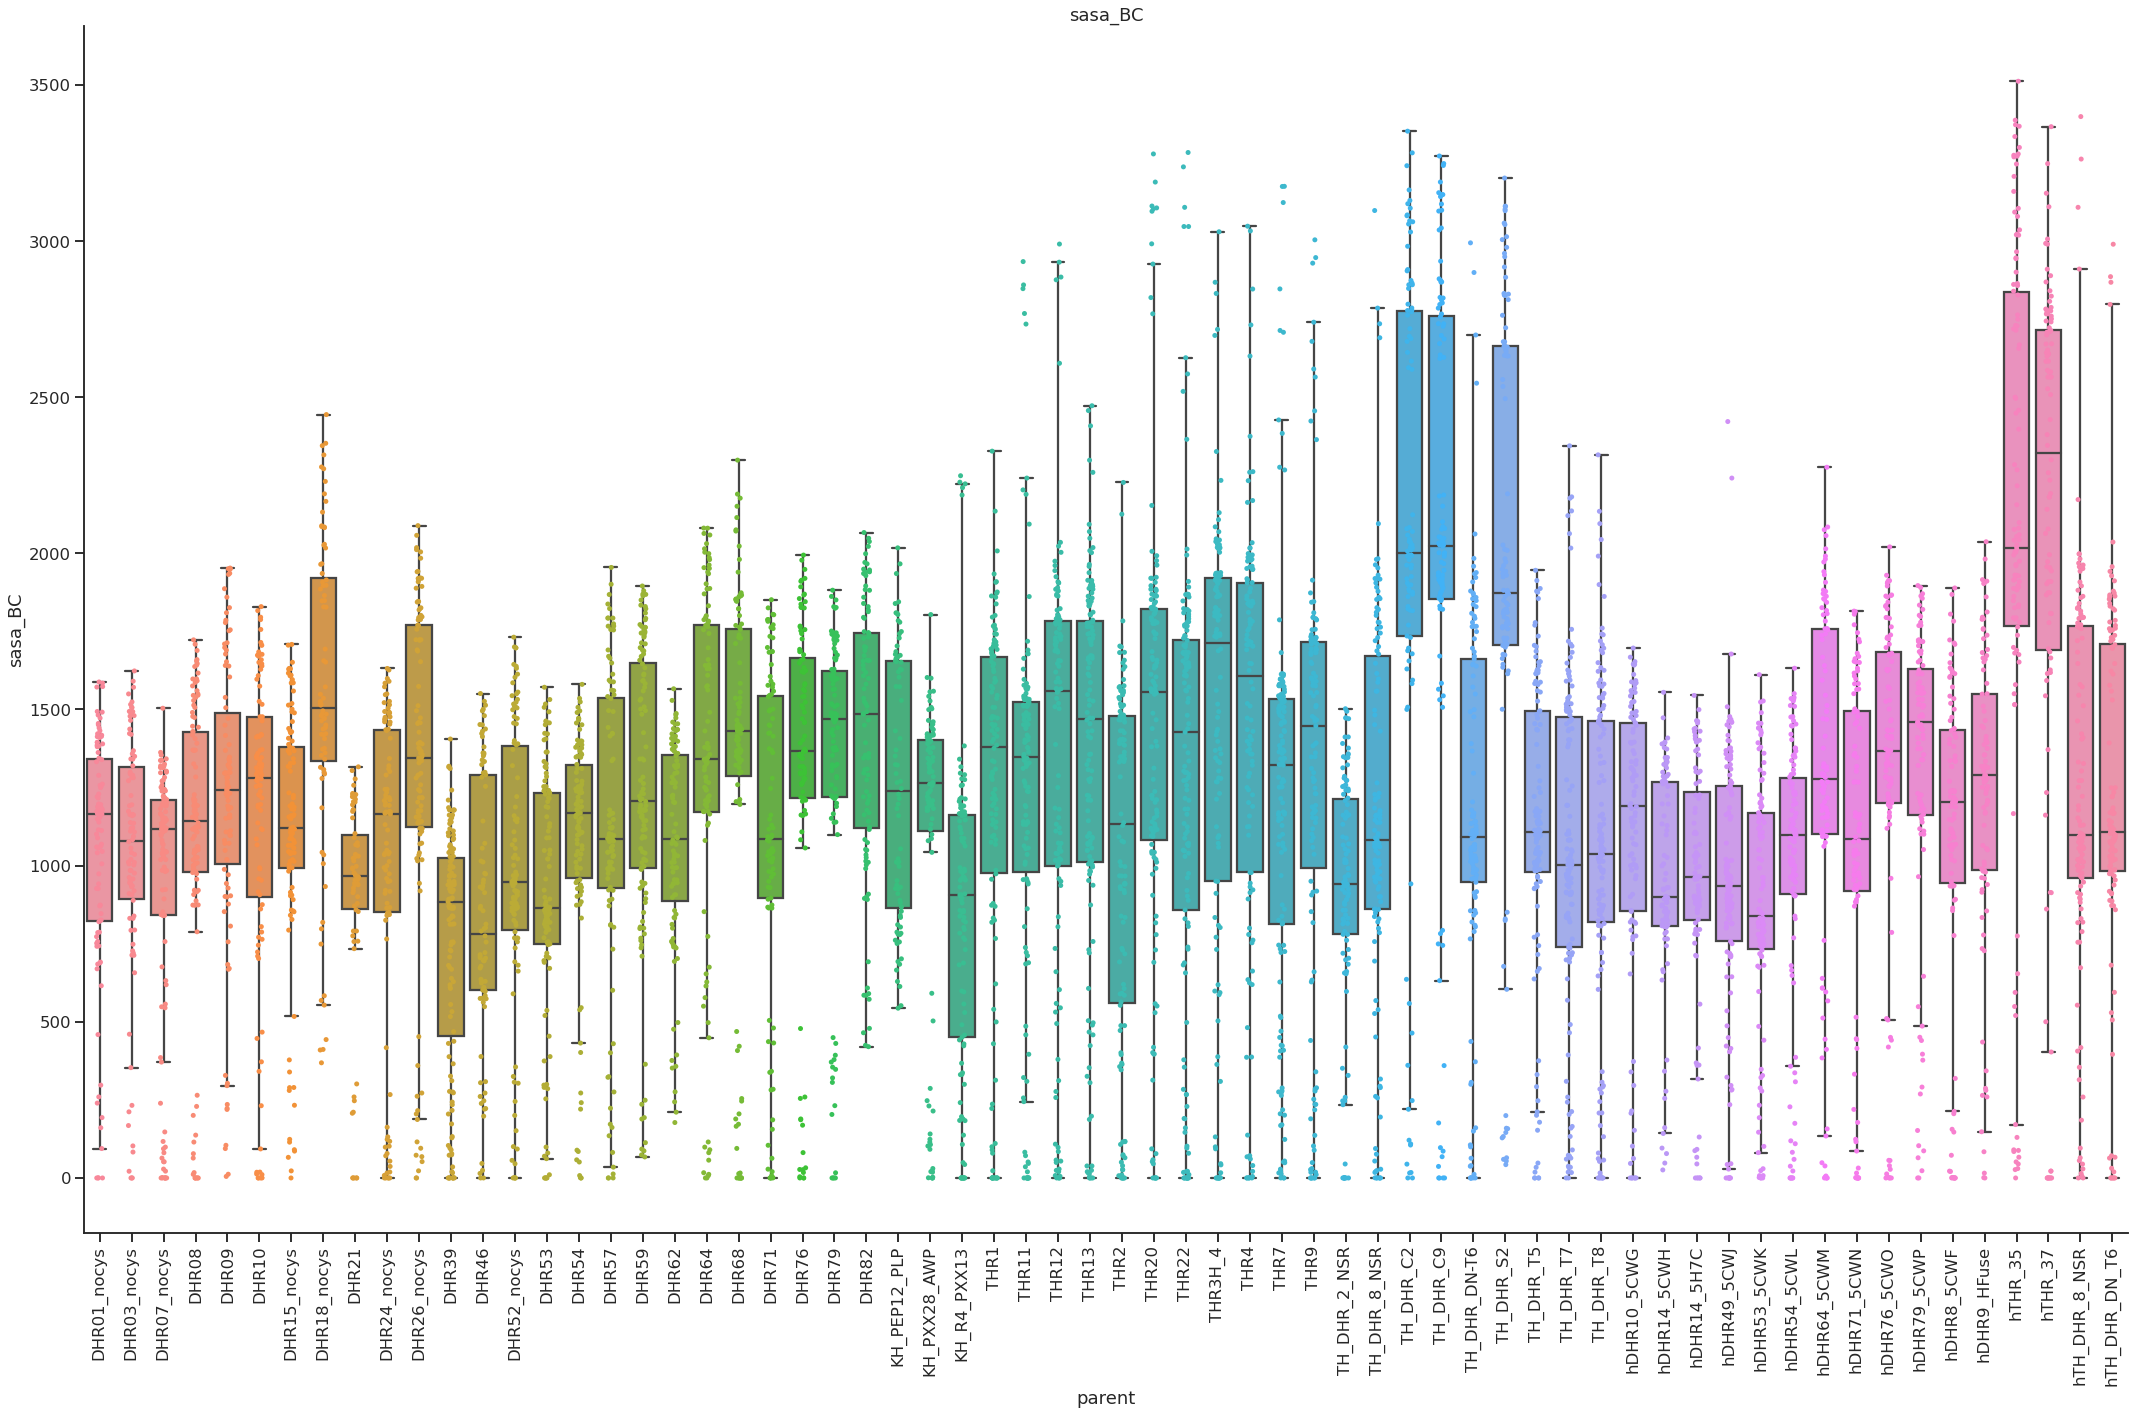

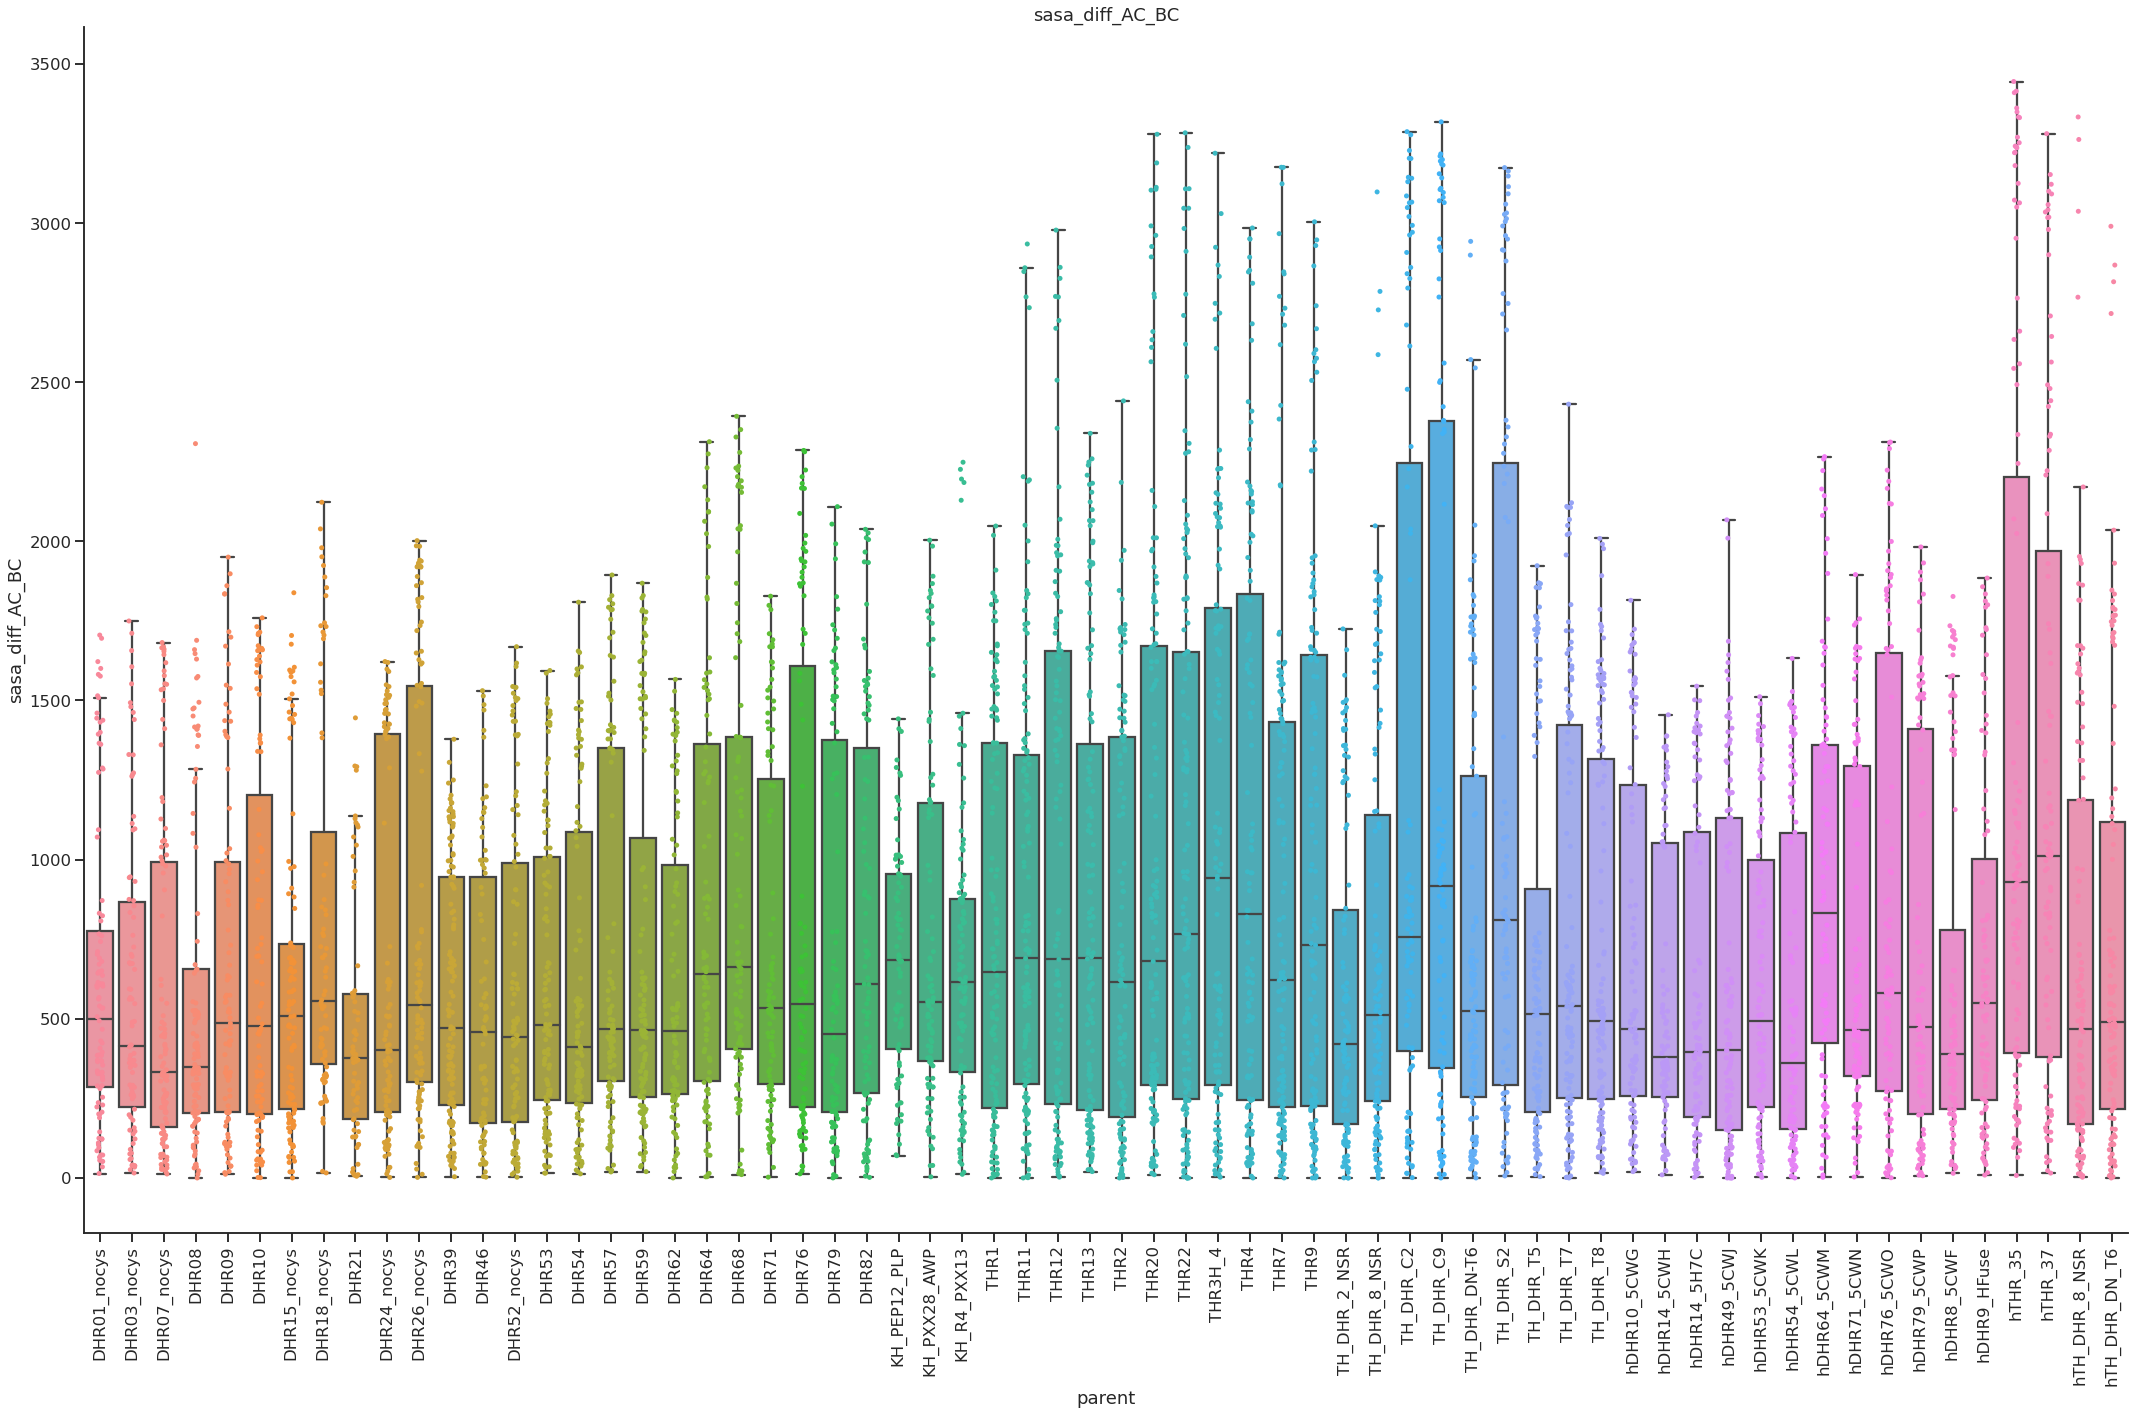

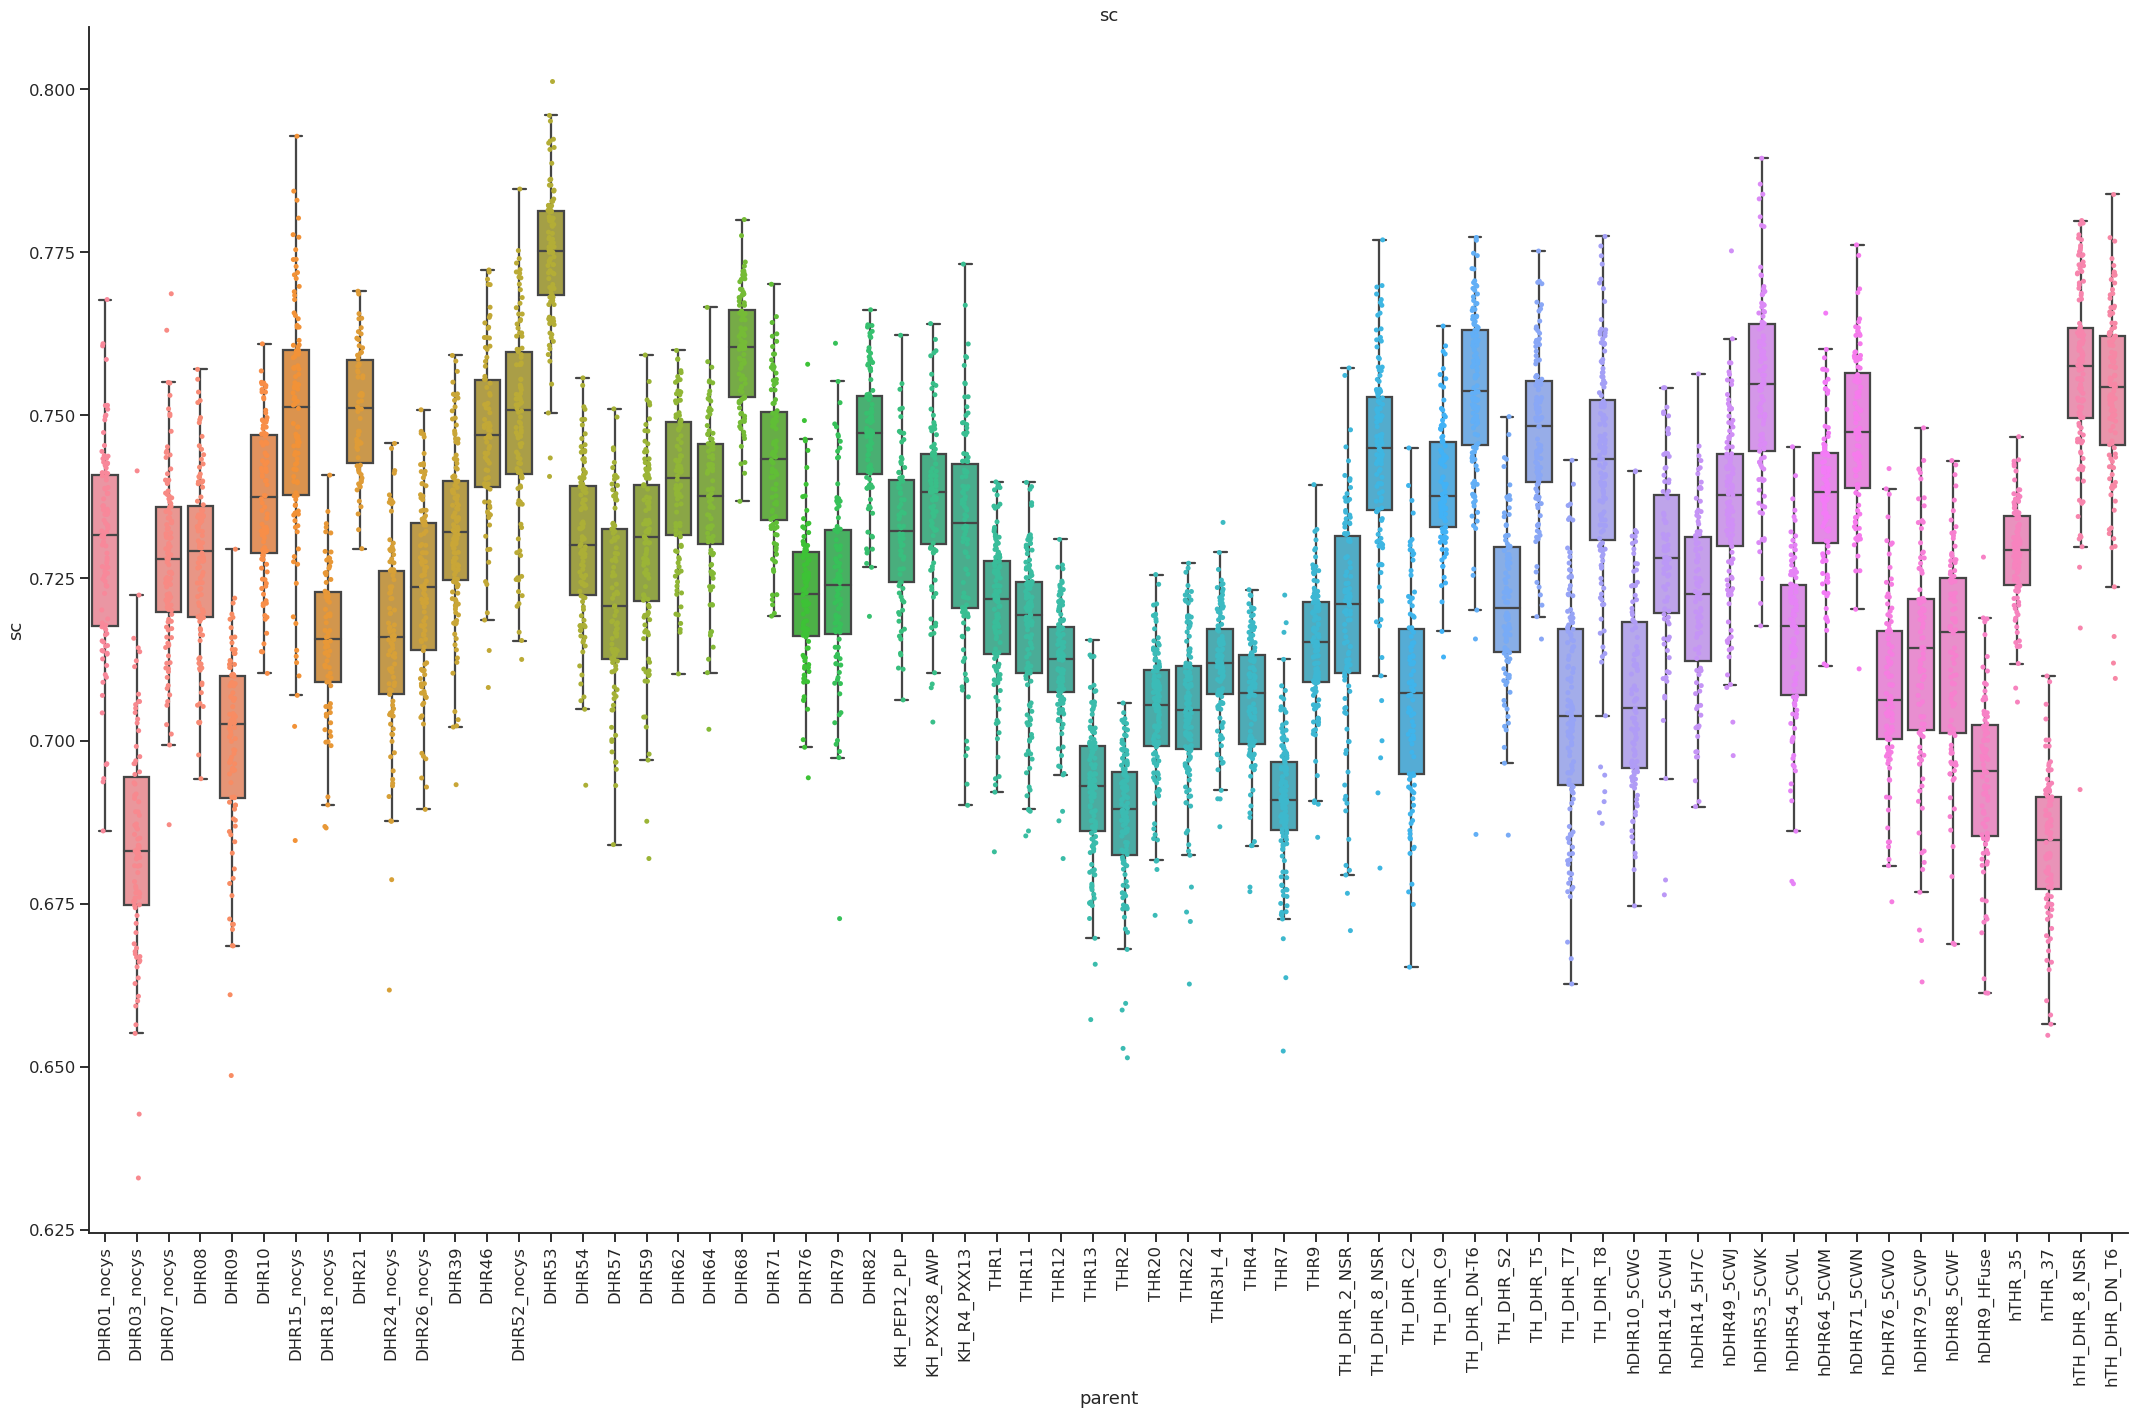

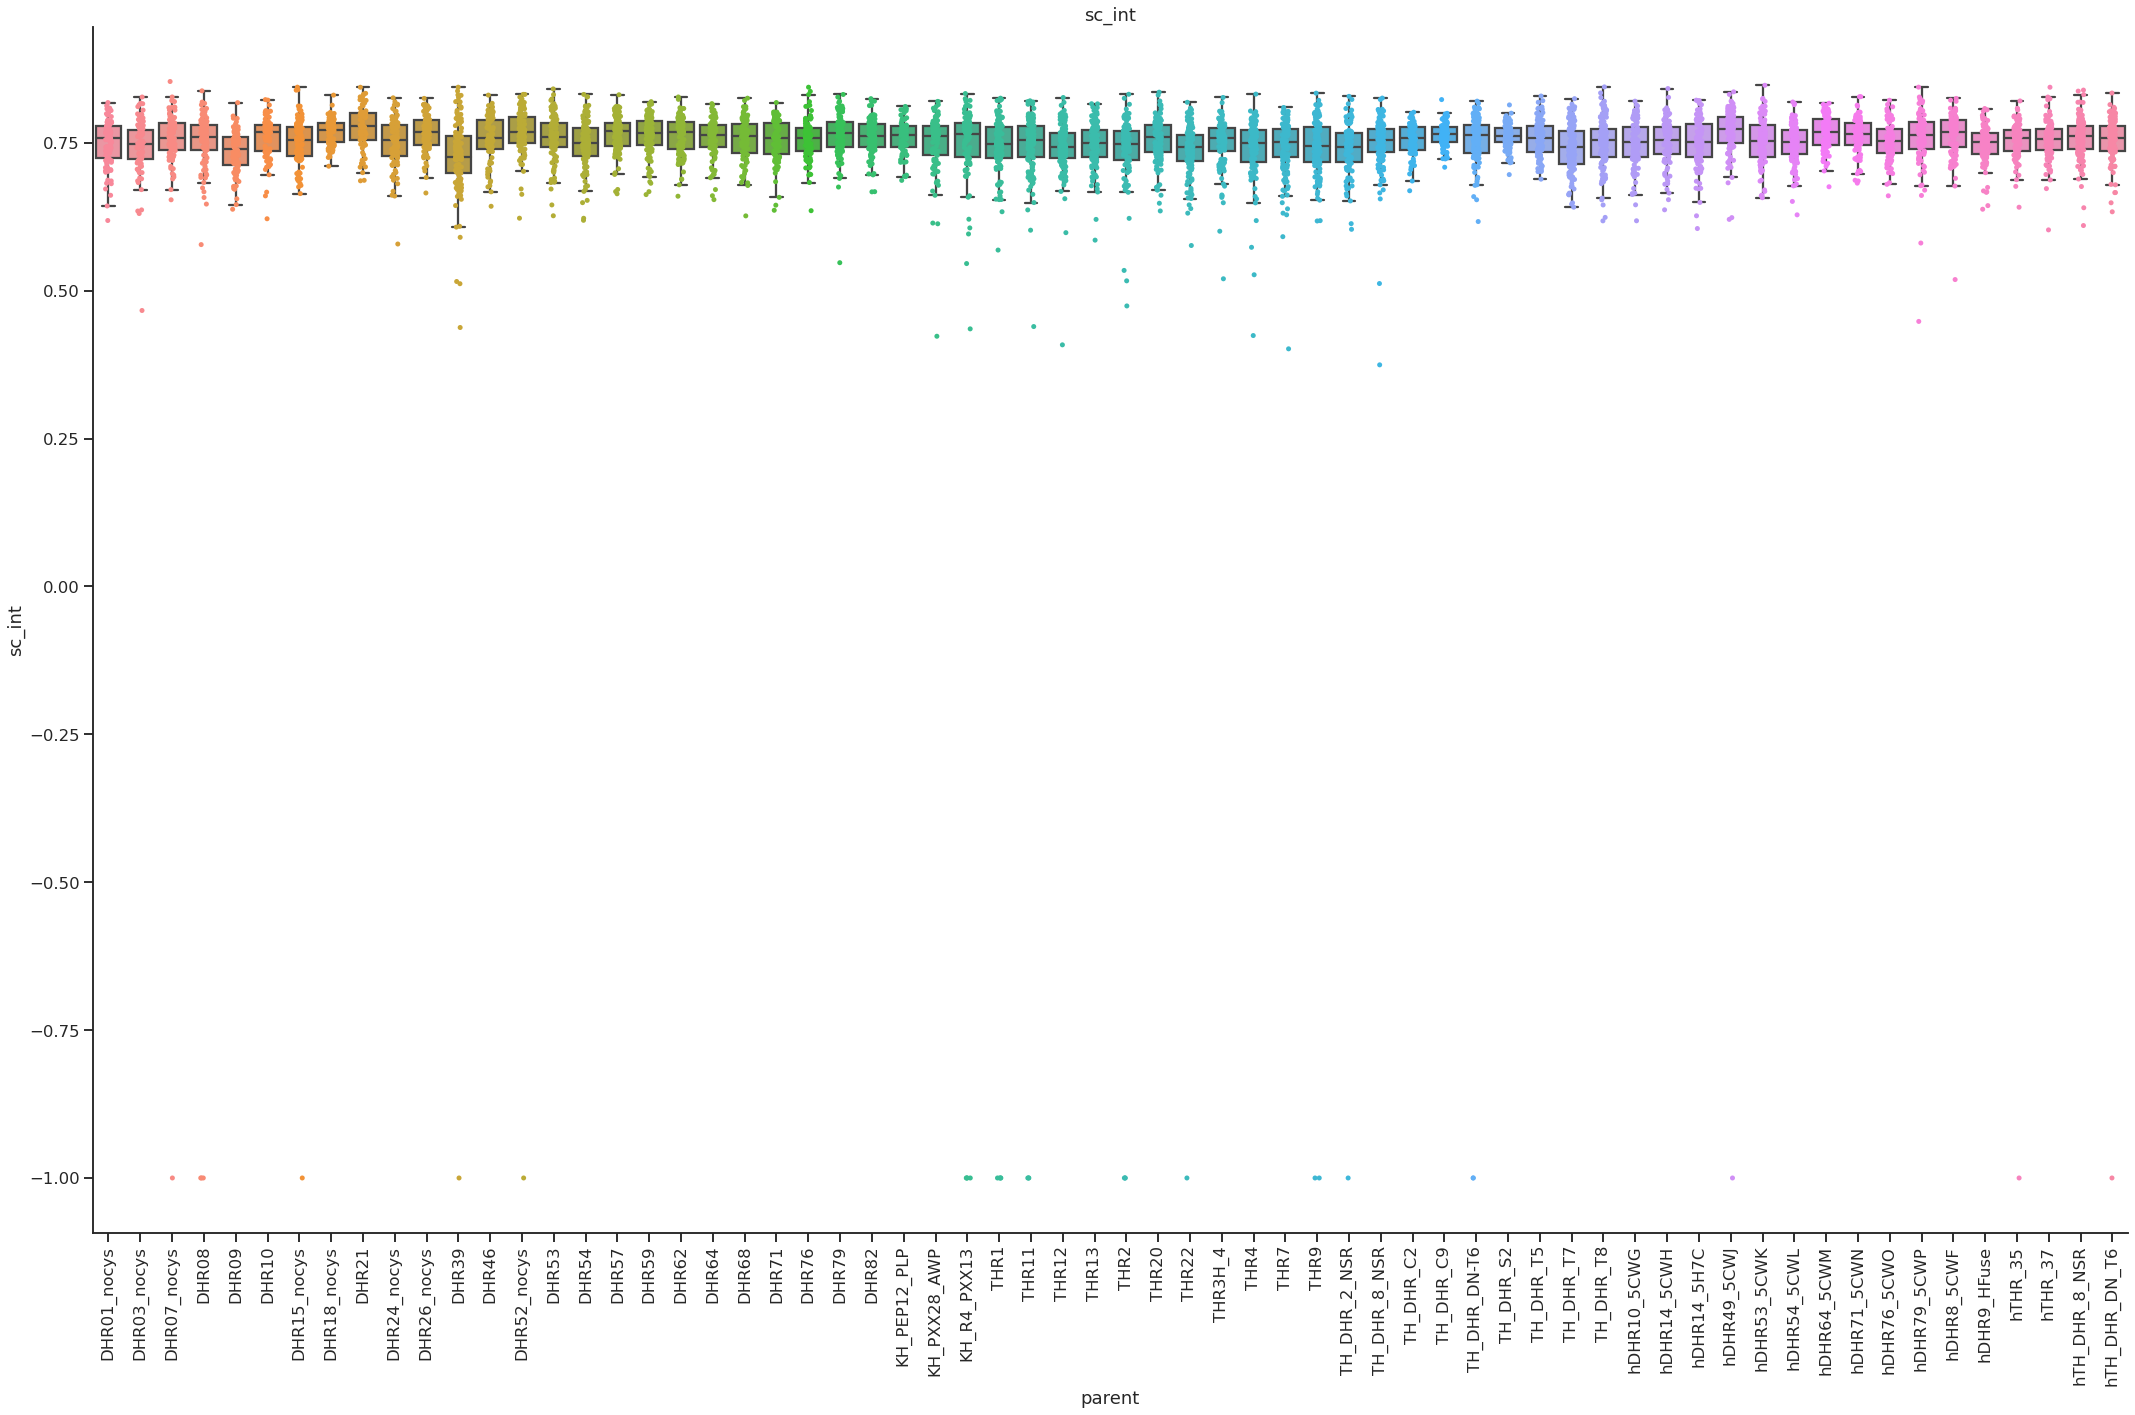

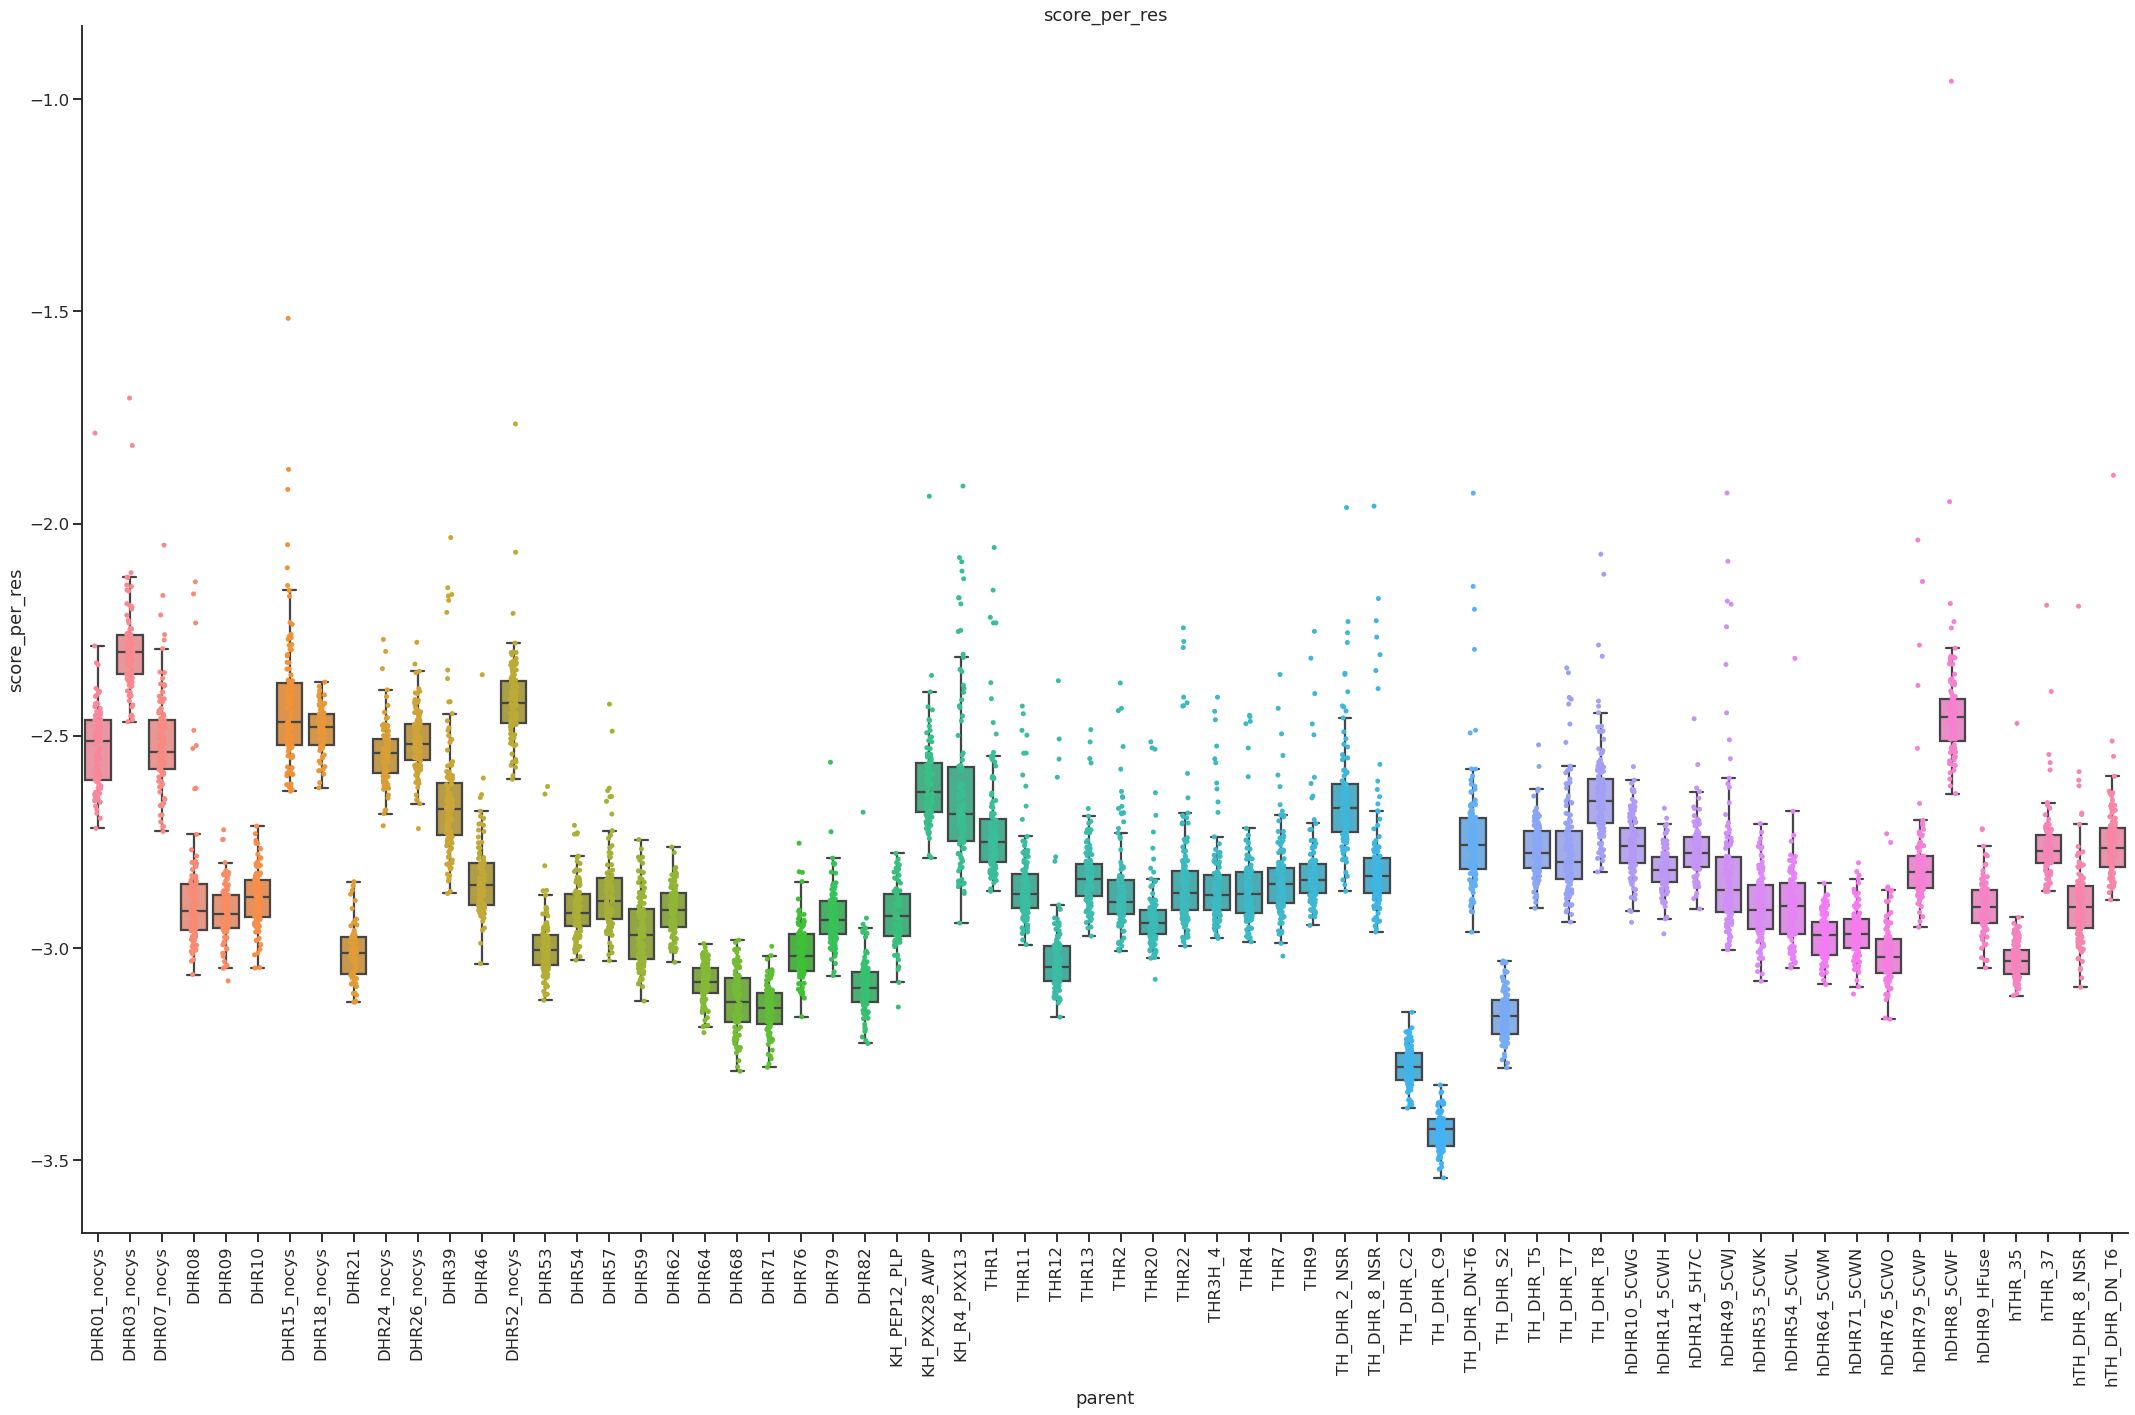

In [22]:
sns.set(
    context="talk",
    font_scale=1,  # make the font larger; default is pretty small
    style="ticks",  # make the background white with black lines
    palette="colorblind",  # a color palette that is colorblind friendly!
)
terms = [
    "sasa_AB",
    "sasa_AC",
    "sasa_BC",
    "sasa_diff_AC_BC",
    "sc",
    "sc_int",
    "score_per_res",
]
order = sorted(list(set(scores_df.parent.values)))
for term in terms:
    fig = plt.figure(figsize=(30, 20), tight_layout=True)
    plt.xticks(rotation=90)
    sns.boxplot(
        x="parent",
        y=term,
        data=scores_df,
        showfliers=False,
        order=order,
    )
    sns.stripplot(
        x="parent",
        y=term,
        data=scores_df,
        order=order,
    )
    sns.despine()
    plt.title(term)
    plt.show()
    plt.close()
    fig.suptitle(f"{term} scores by parent pre selection")
    fig.savefig("figs/02_before_selection_all_parents_vs_{term}.png".format(term=term))

### Group by parent scaffold then discard worst 10% of selected terms
Terms to explore:  
`sasa_AB`, `sasa_AC`, `sasa_BC`, `sasa_diff_AC_BC`, `sc`, `sc_int`, `score_per_res`

In [31]:
unique_parents = set(scores_df.parent.values)
scoreterms = [
    "sasa_AB",
    "sasa_AC",
    "sasa_BC",
    "sasa_diff_AC_BC",
    "sc",
    "sc_int",
    "score_per_res",
]
not_bad = []
for unique_parent in unique_parents:
    temp_df = scores_df[scores_df["parent"] == unique_parent]
    top_percentiles, bottom_percentiles = {}, {}
    for term in scoreterms:  # get the 10th percentile of each term
        bottom_percentiles[term] = temp_df[term].quantile(0.10)
        top_percentiles[term] = temp_df[term].quantile(0.90)
    for (
        index,
        row,
    ) in temp_df.iterrows():  # make sure each row meets or exceeds the 10th percentile
        passed = True
        for term in scoreterms:
            if term not in ["score_per_res", "sasa_diff_AC_BC"]:
                if row[term] >= bottom_percentiles[term]:
                    pass
                else:
                    passed = False
                    break
            else:  # score_per_res; sasa_diff_AC_BC lower is better
                if row[term] <= top_percentiles[term]:
                    pass
                else:
                    passed = False
                    break
        if passed:
            not_bad.append(index)

not_bad_df = scores_df.query("index in @not_bad")
len(not_bad_df)

4033

### Check for class imbalance before and after selection

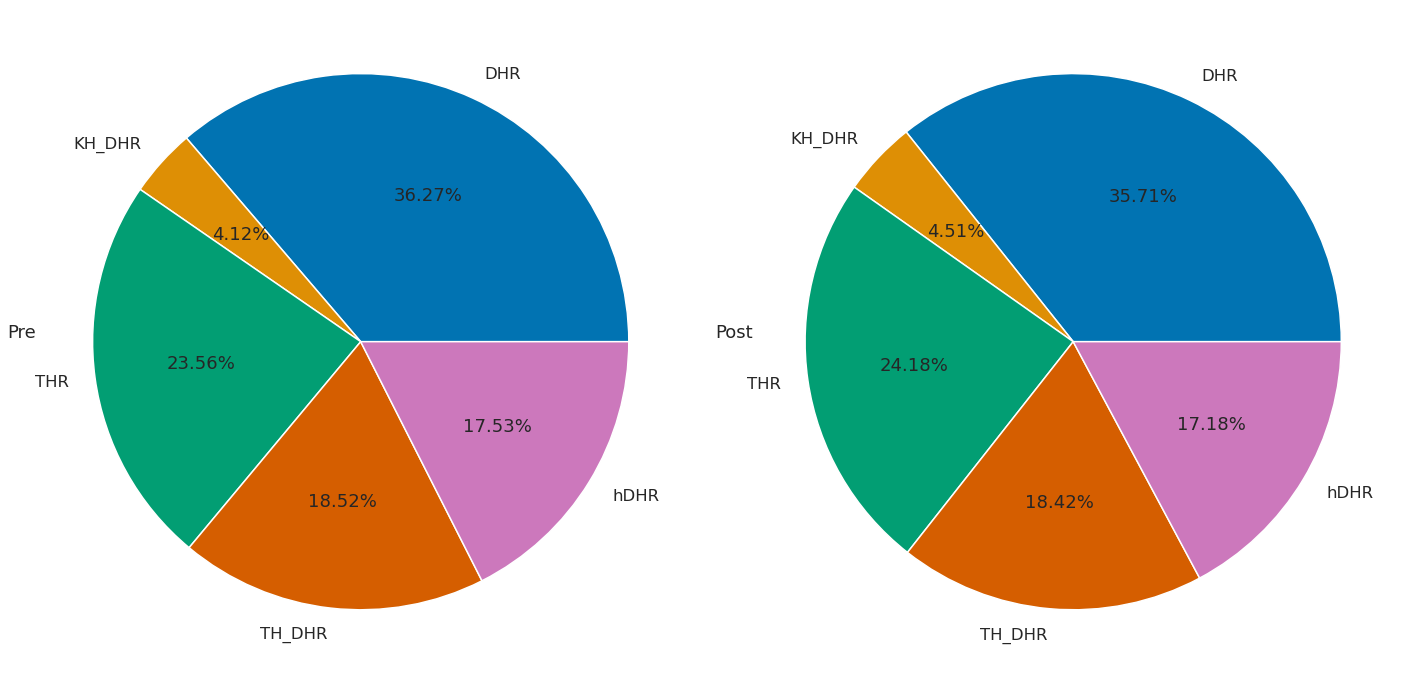

In [32]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 10), tight_layout=True)
scores_df.groupby("scaffold").size().plot(kind="pie", autopct="%1.2f%%", ax=ax1)
not_bad_df.groupby("scaffold").size().plot(kind="pie", autopct="%1.2f%%", ax=ax2)
ax1.set_ylabel("Pre", rotation=0)
ax2.set_ylabel("Post", rotation=0)
plt.tight_layout()
plt.savefig("figs/02_pre_post_selection.png")

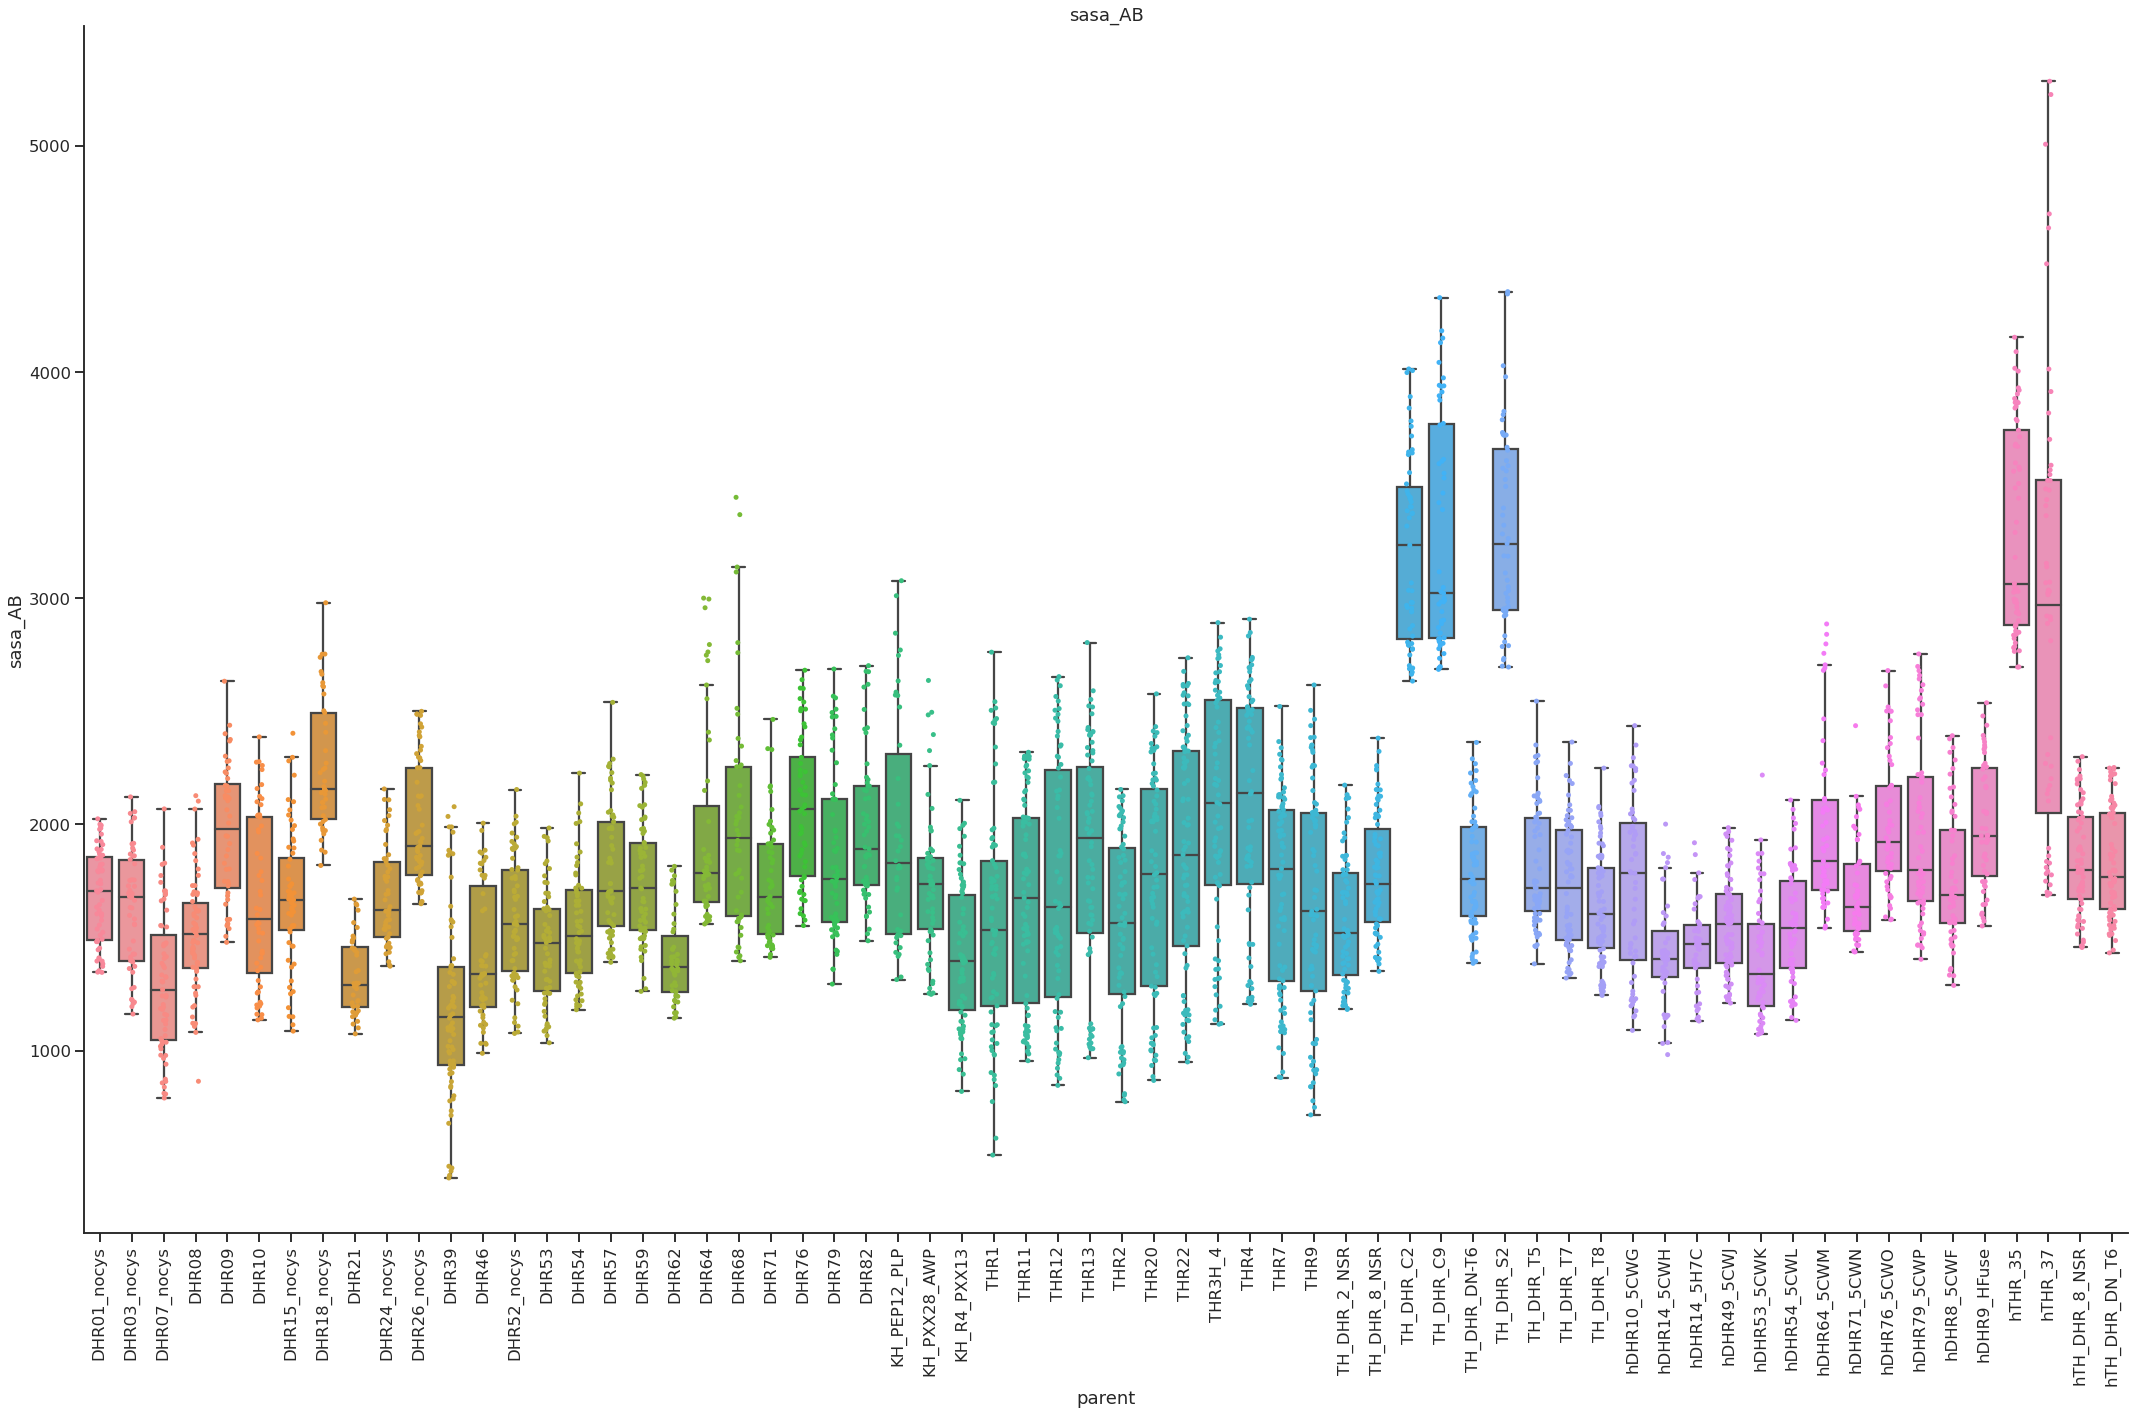

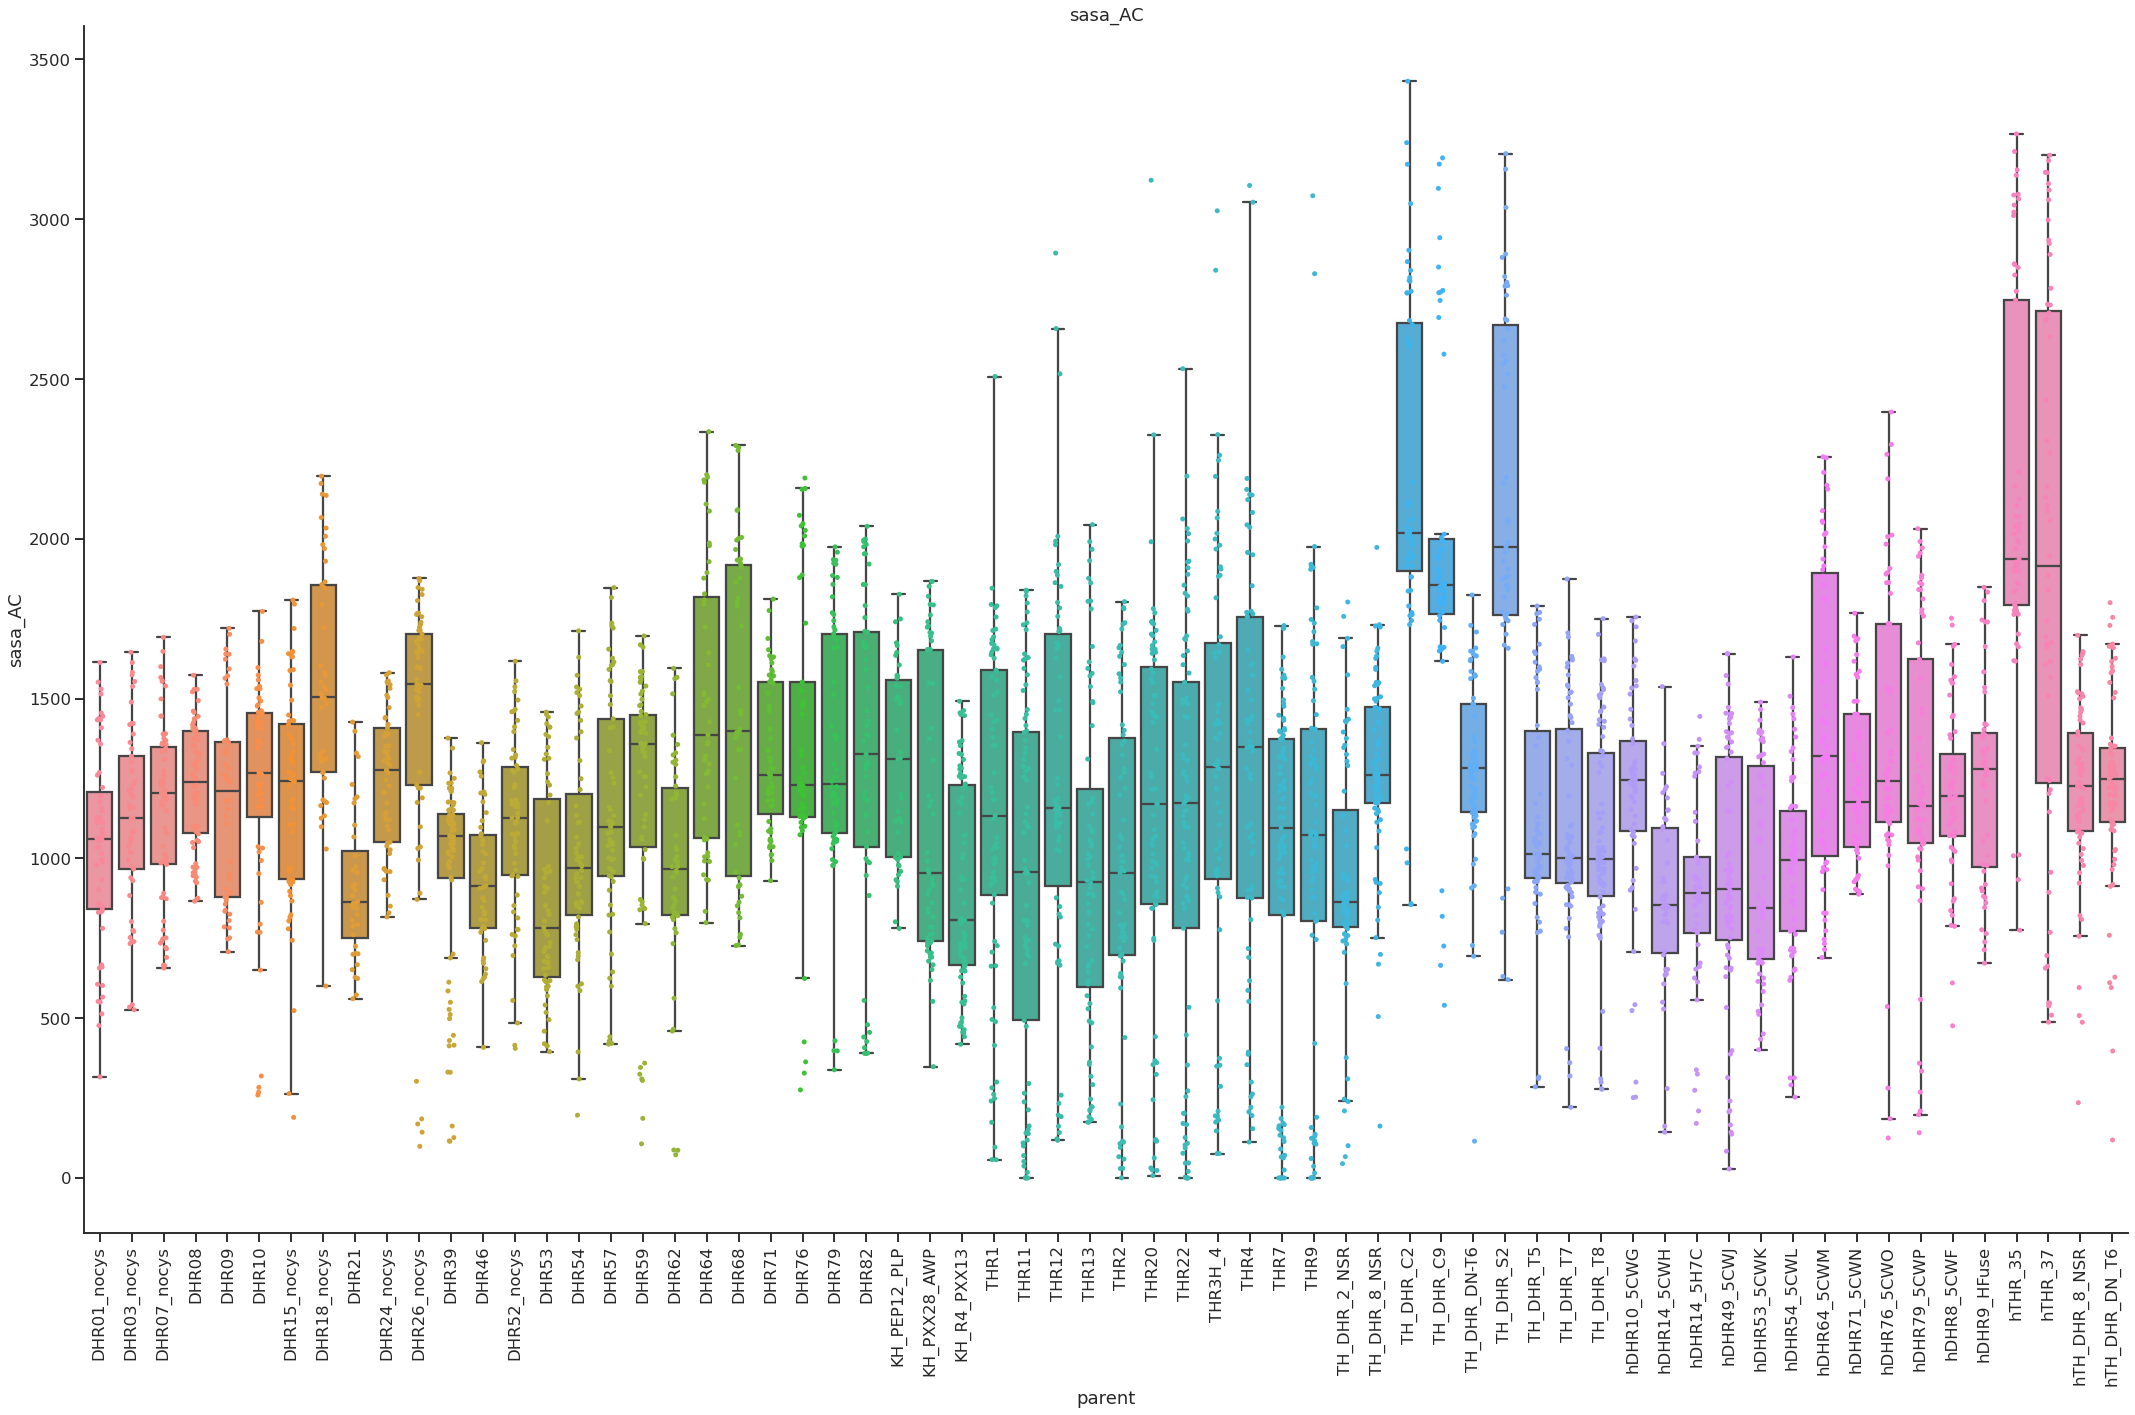

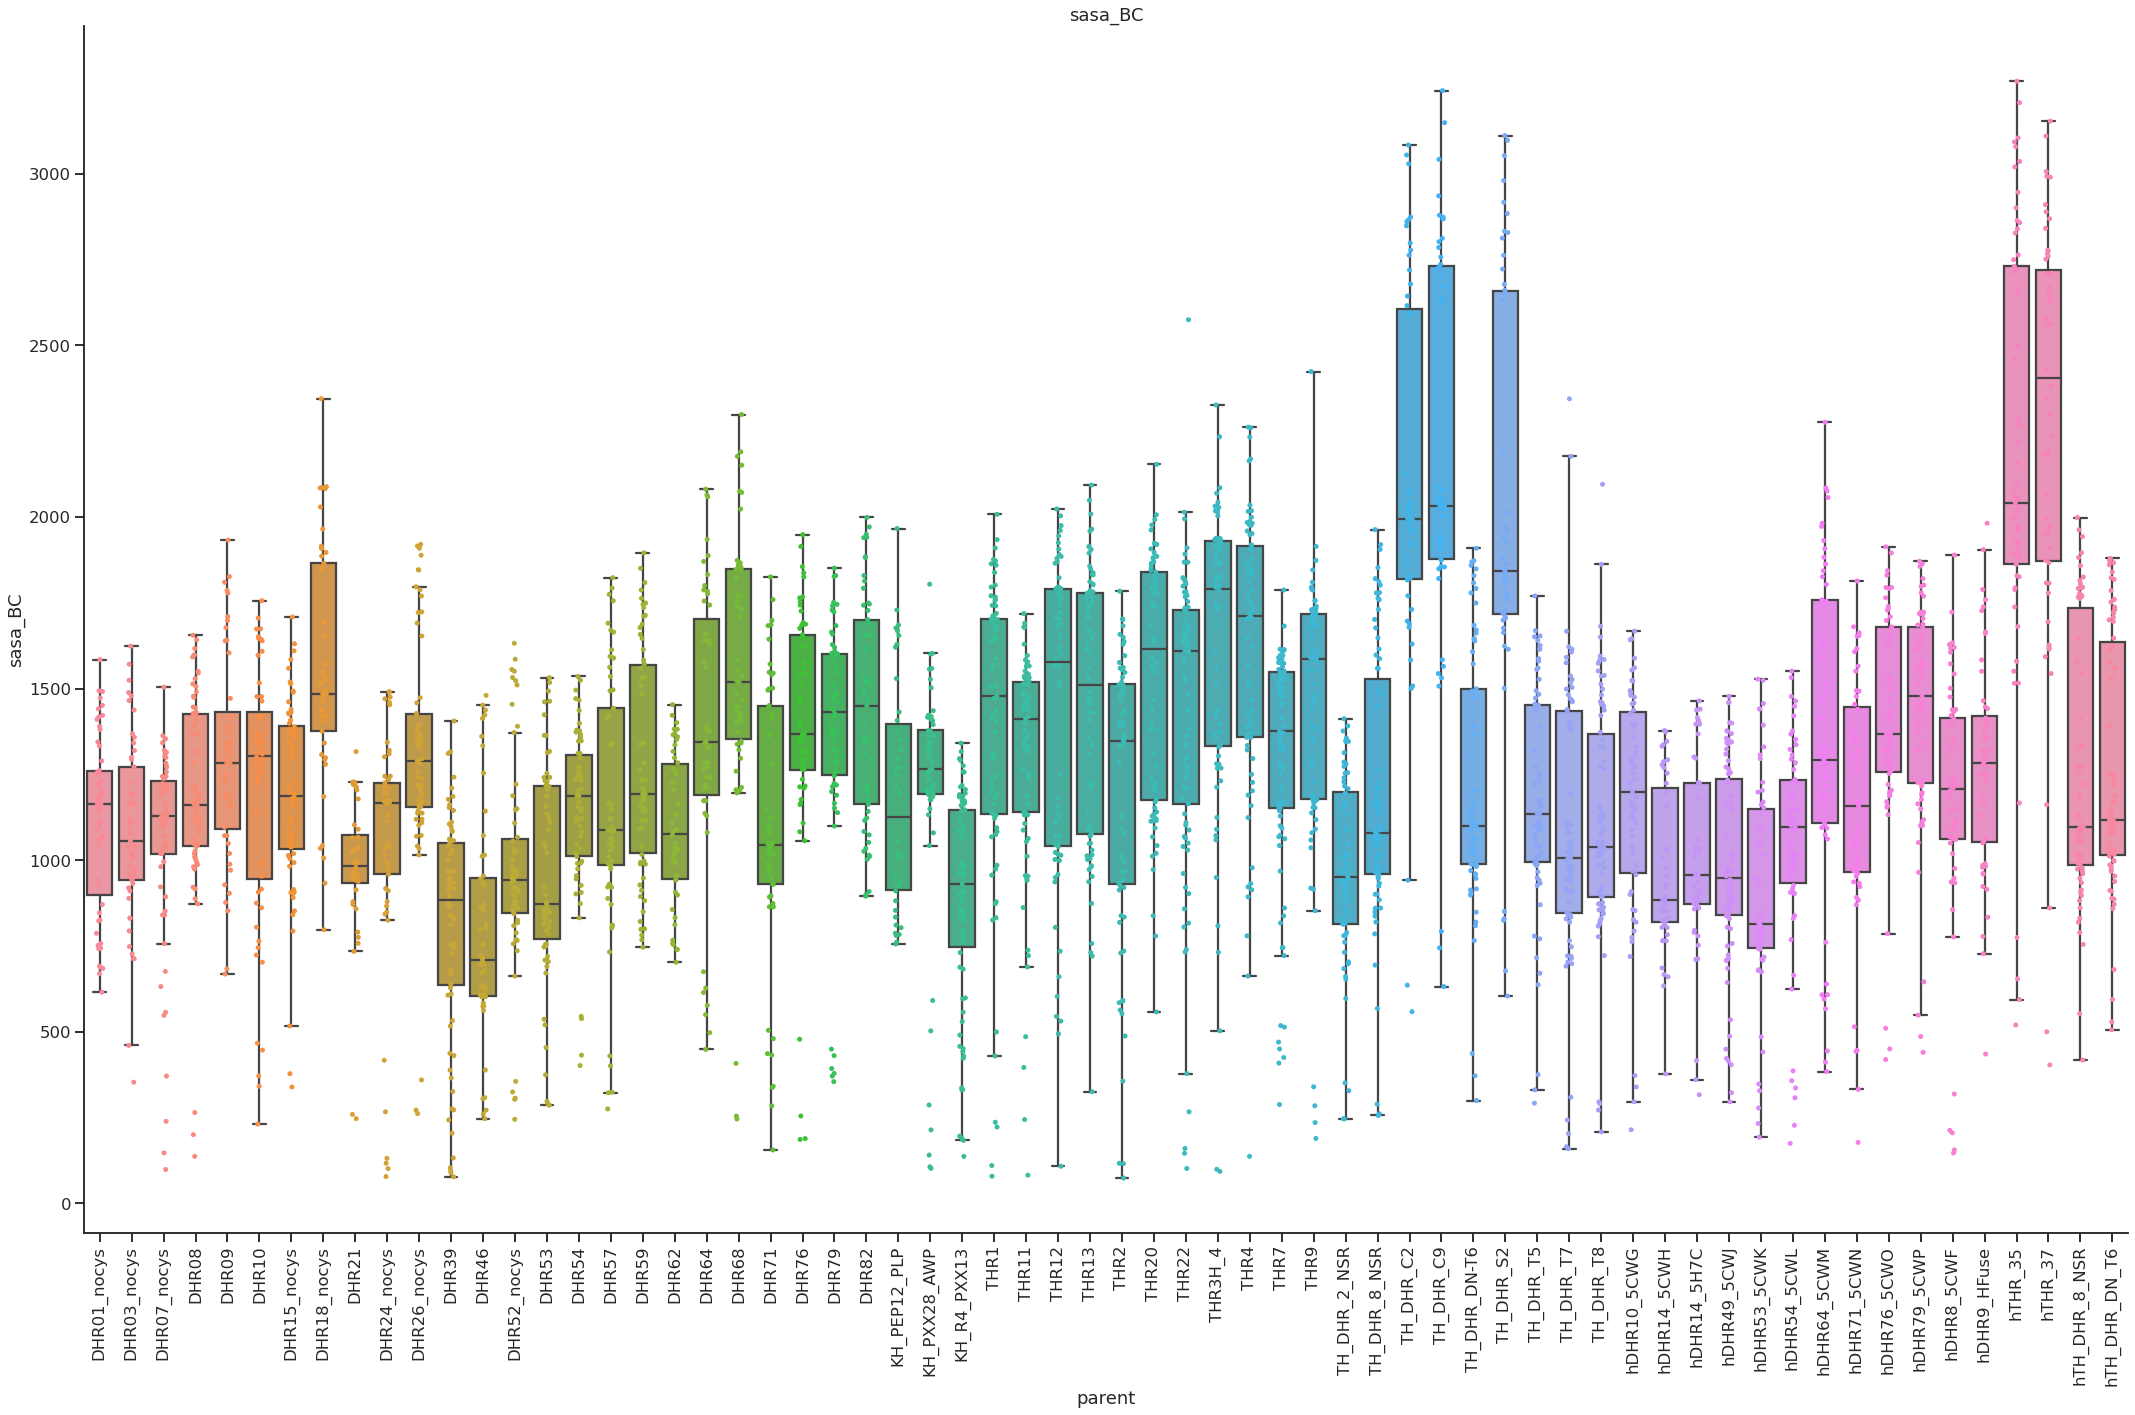

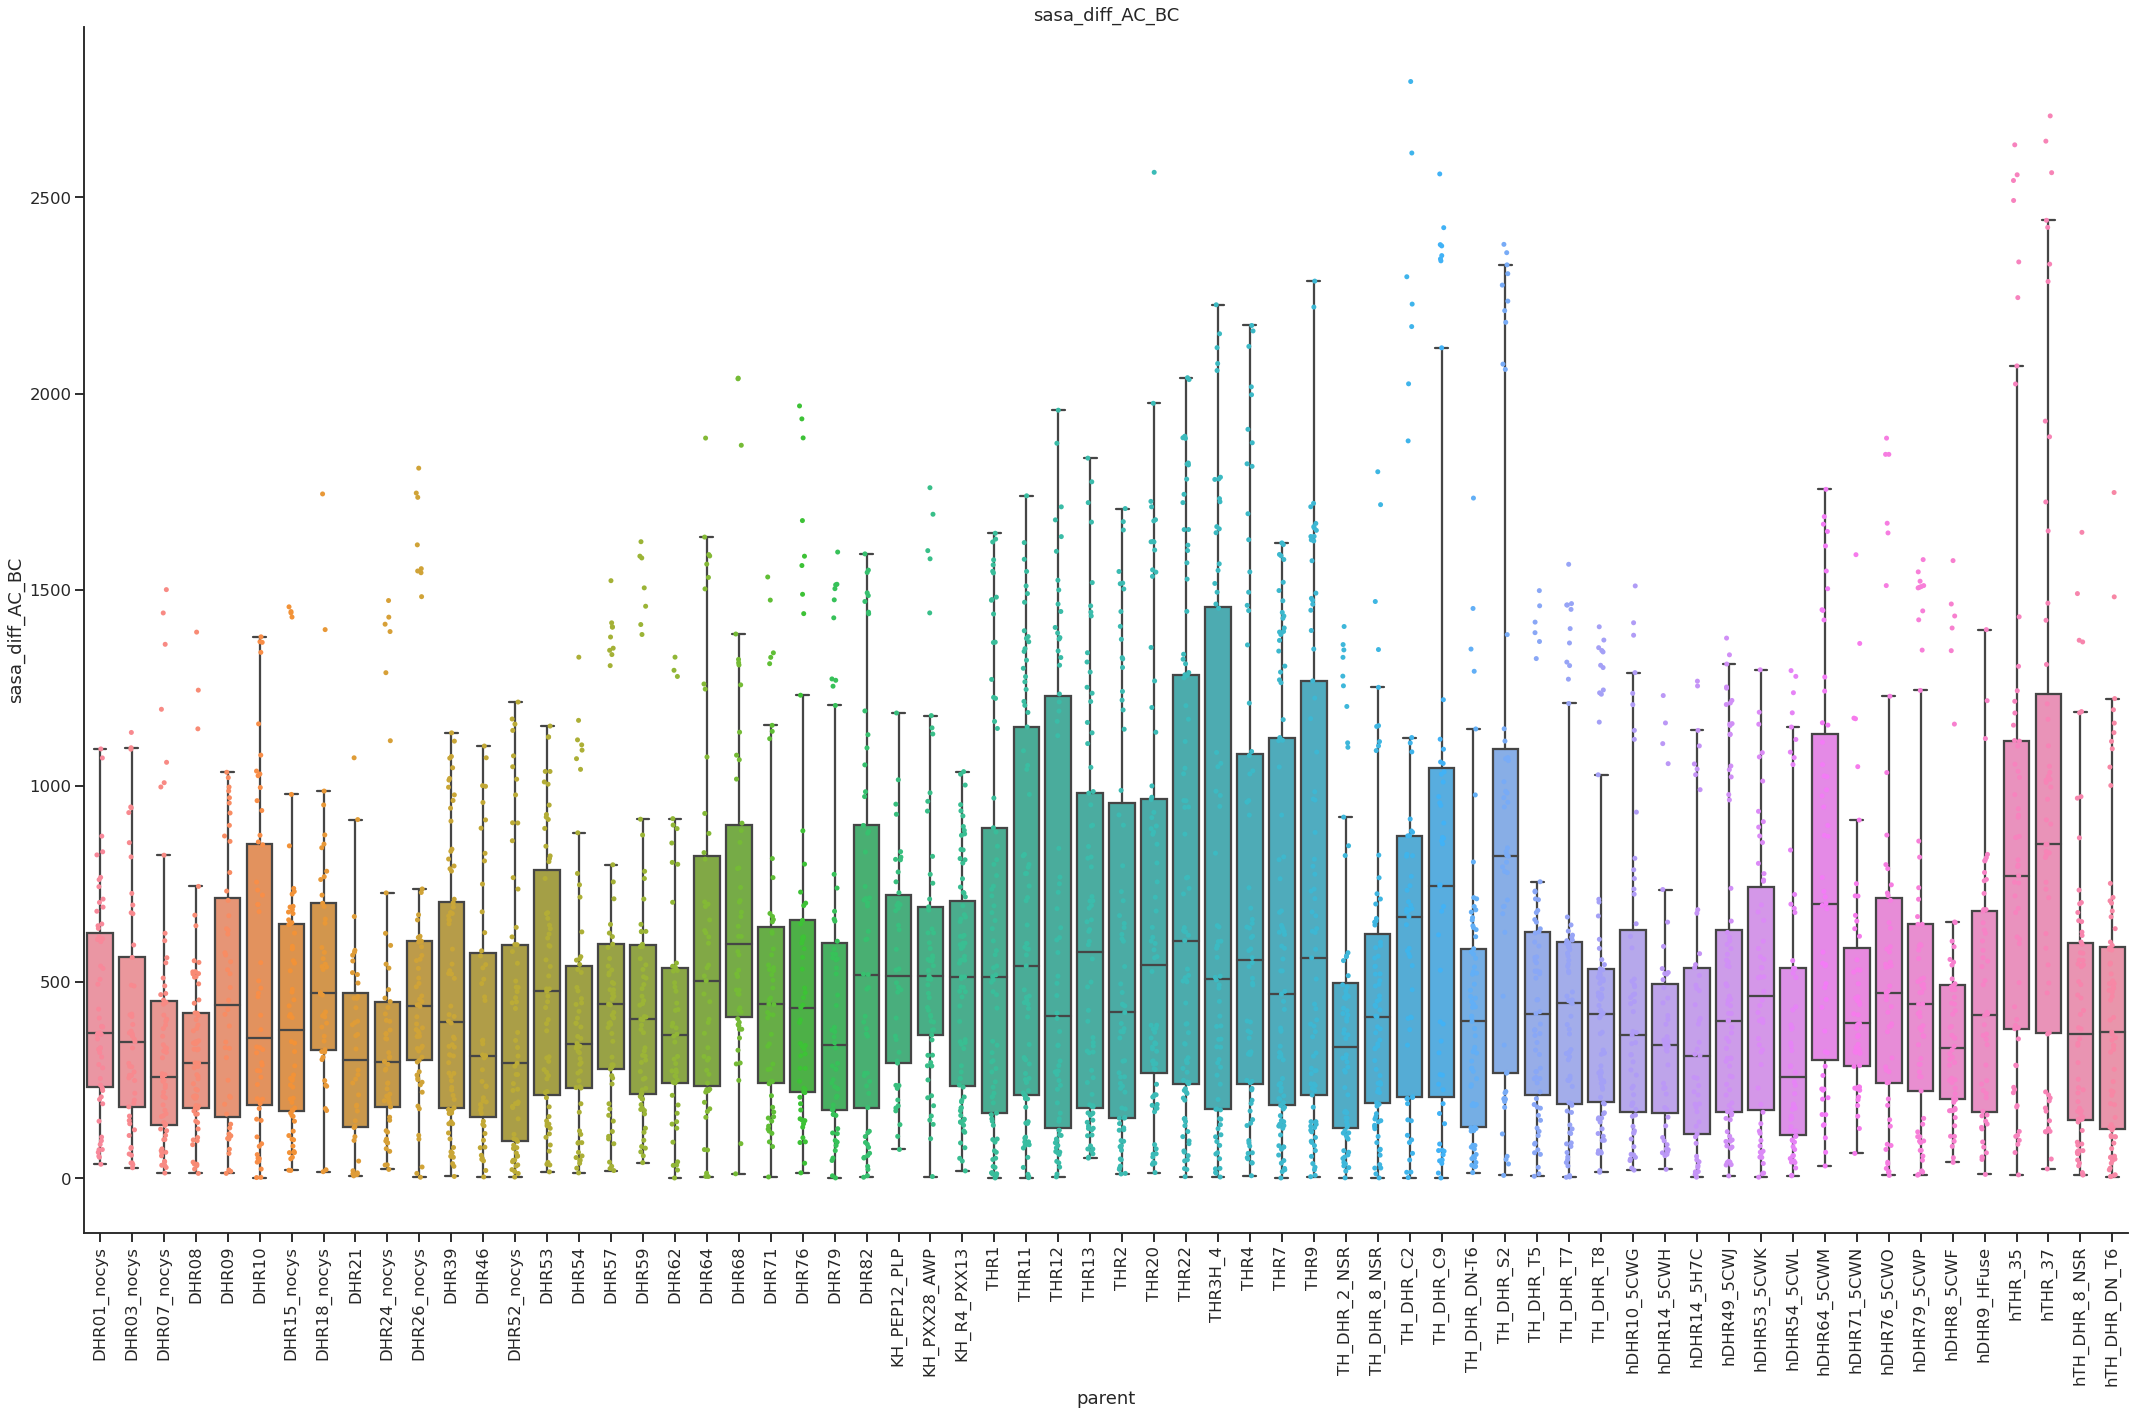

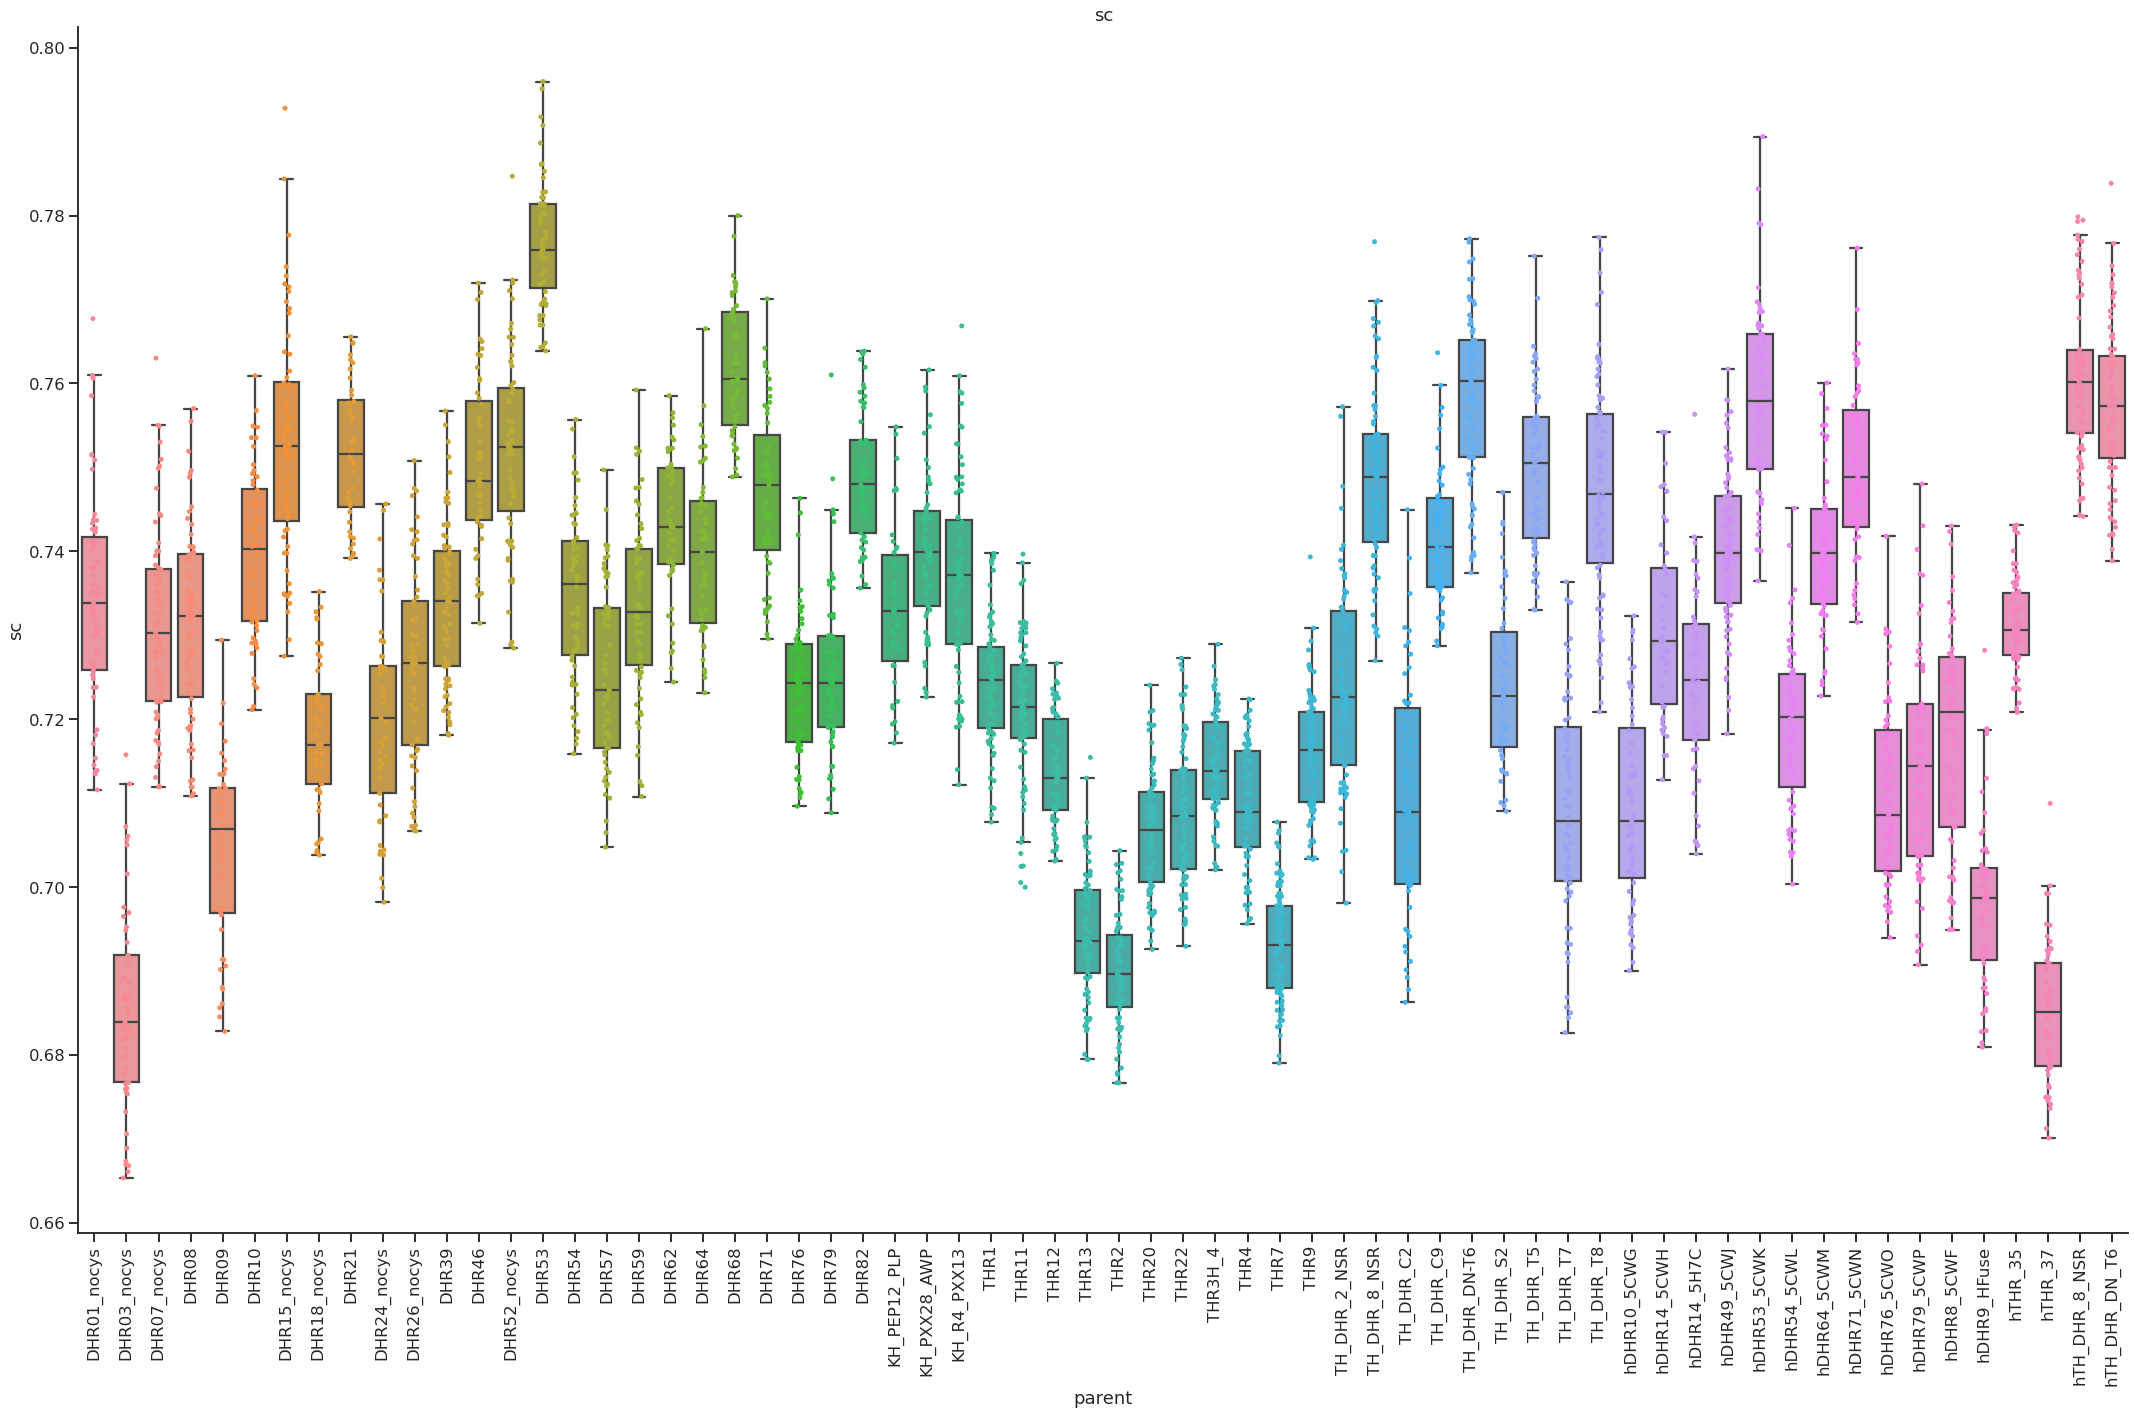

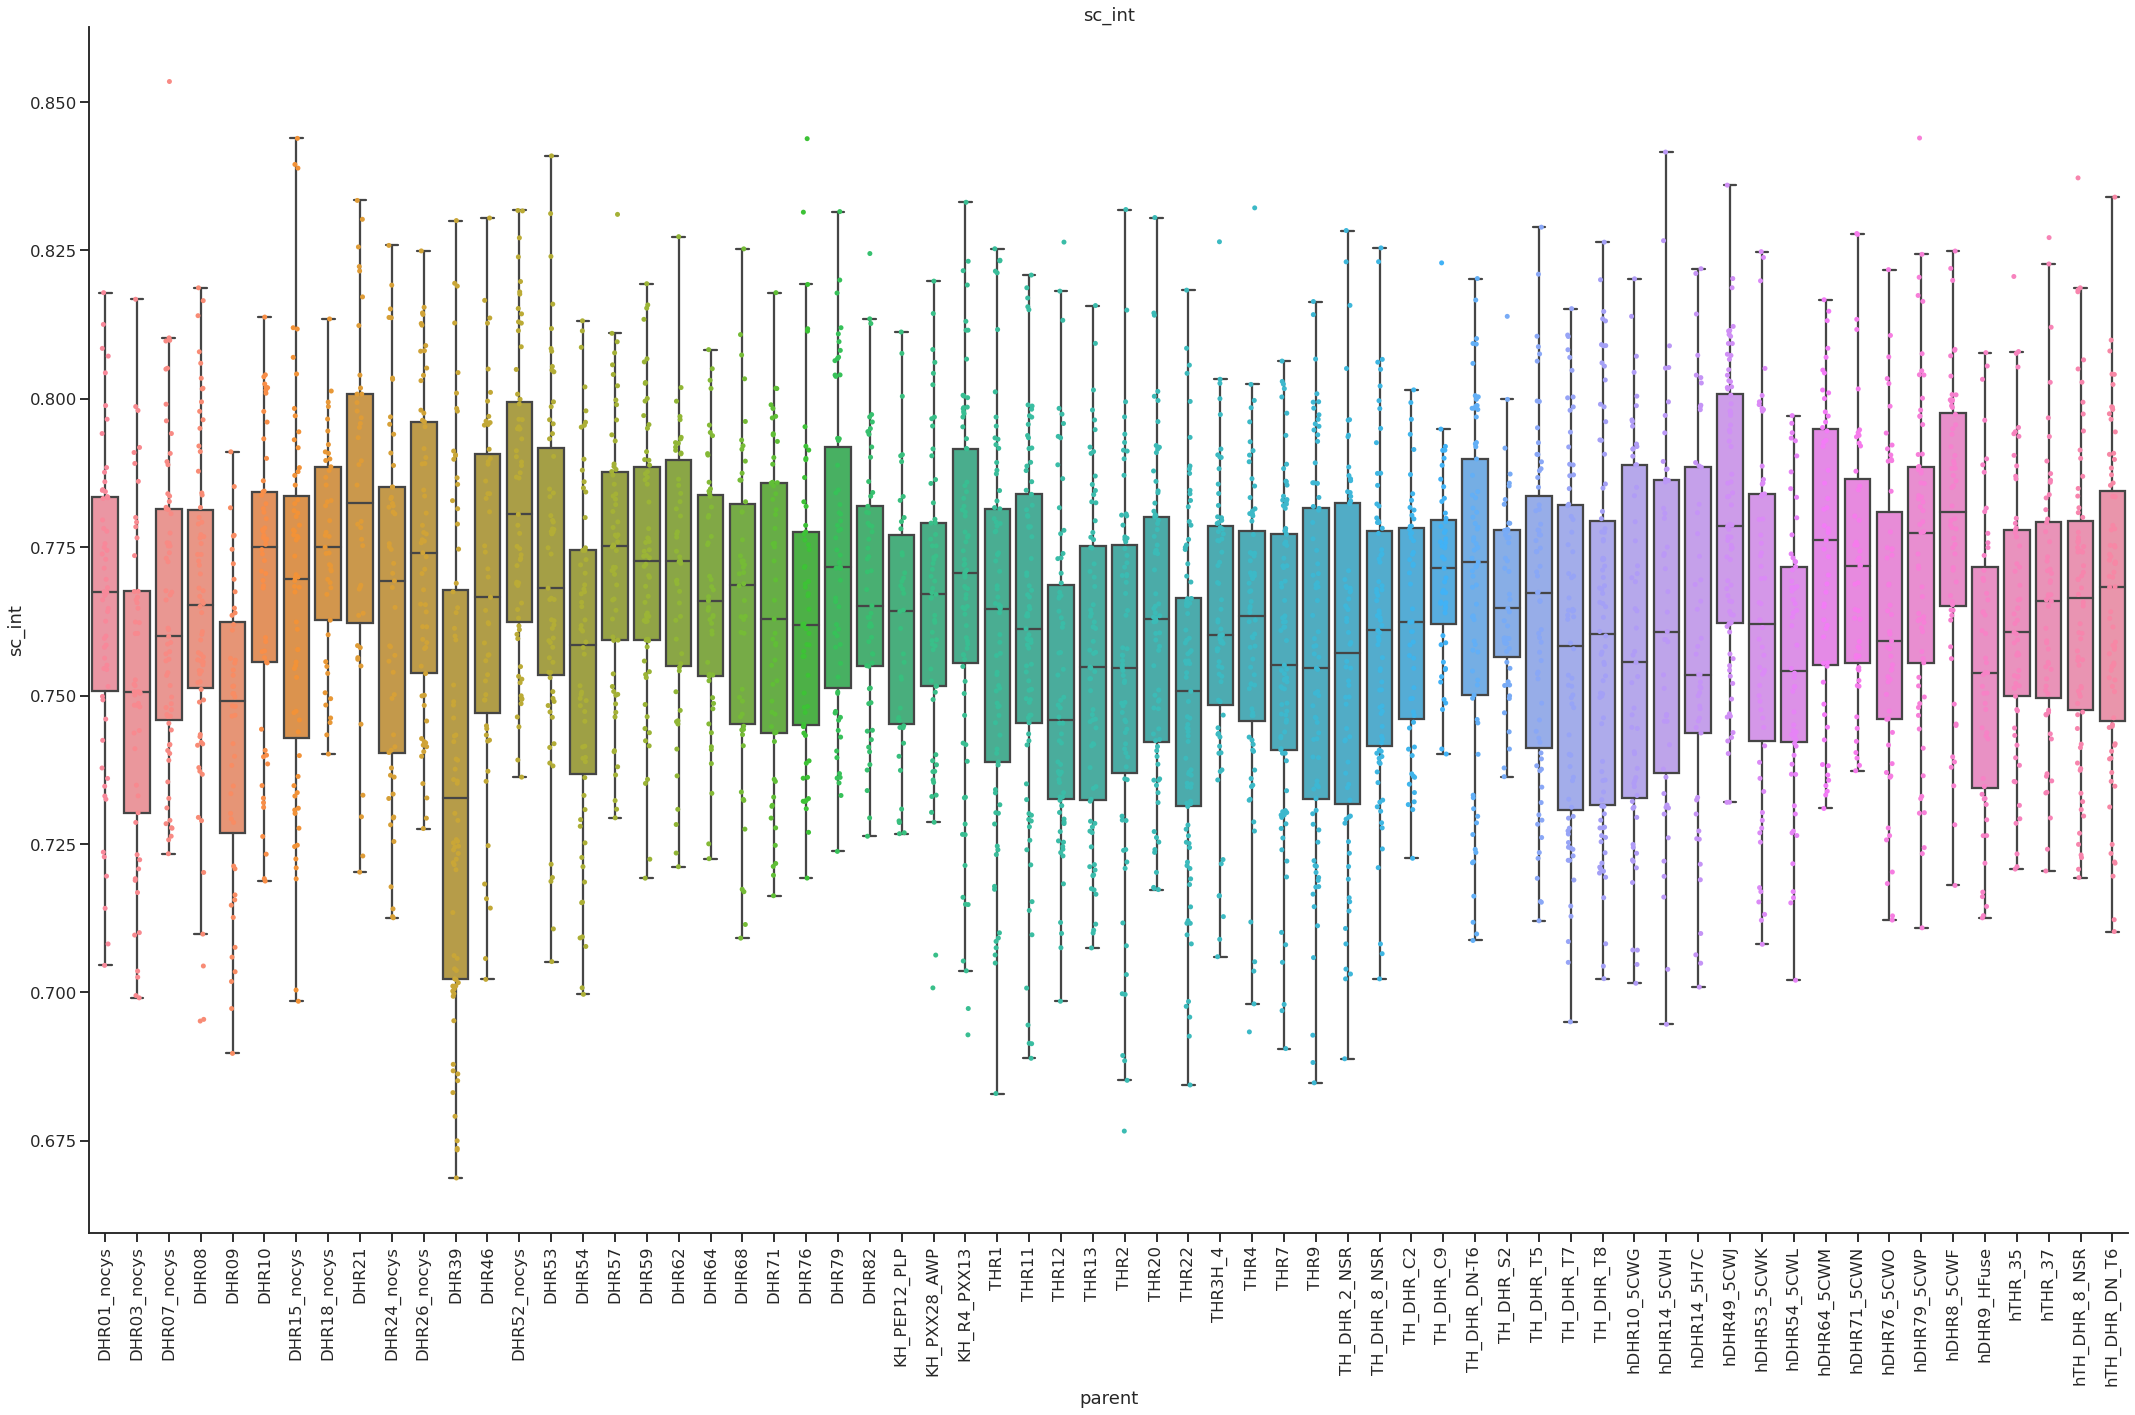

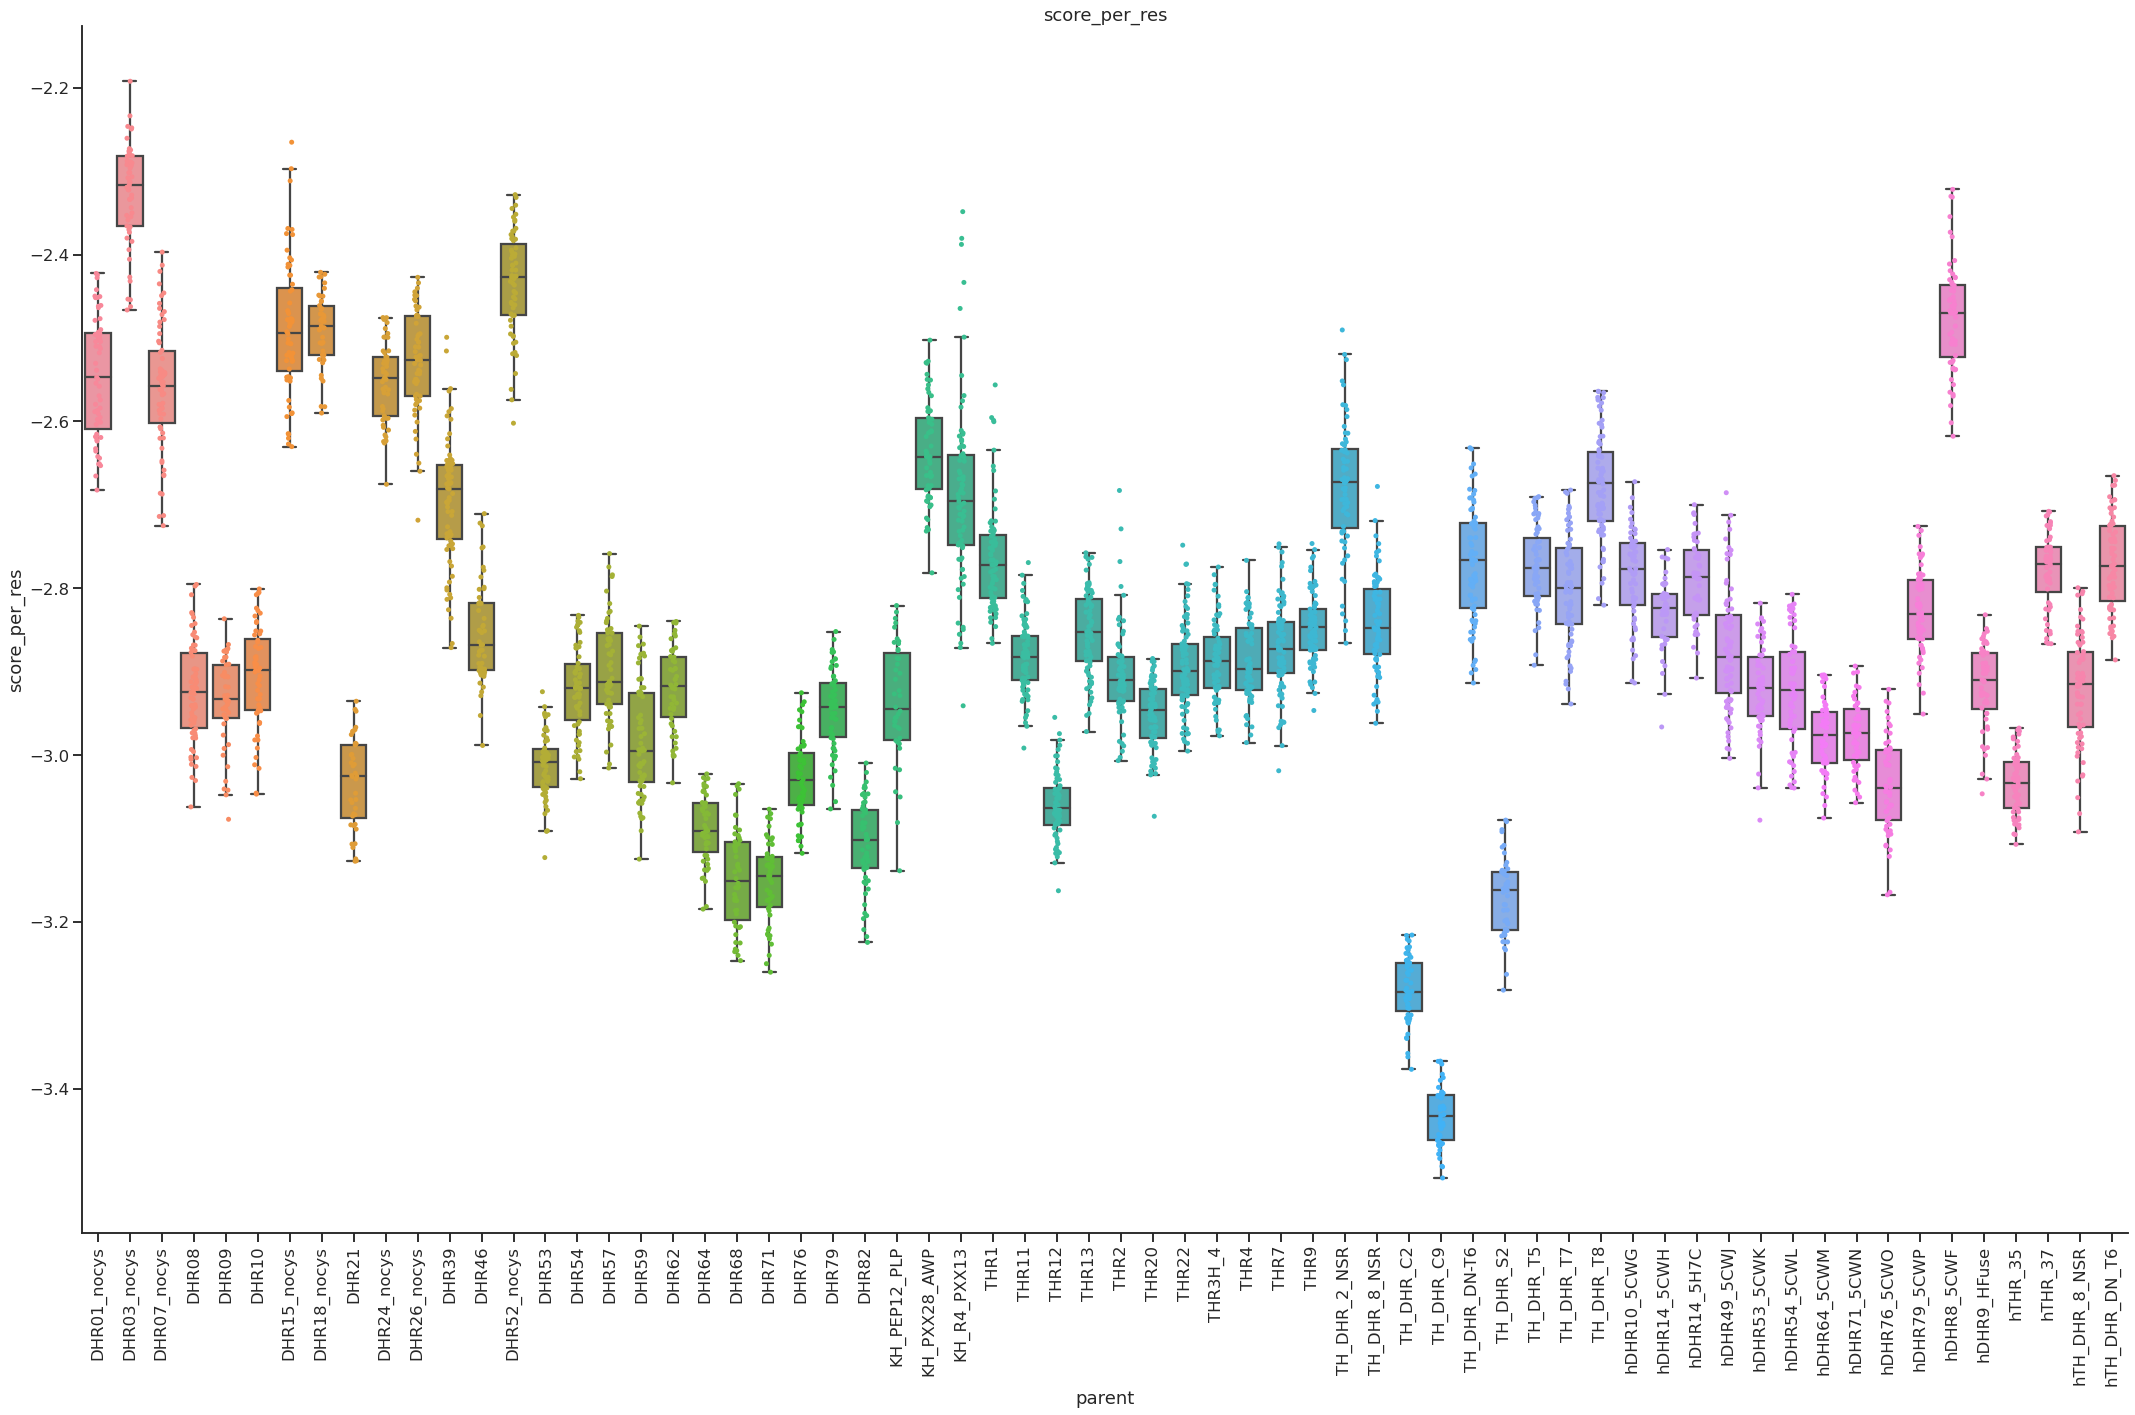

In [34]:
terms = [
    "sasa_AB",
    "sasa_AC",
    "sasa_BC",
    "sasa_diff_AC_BC",
    "sc",
    "sc_int",
    "score_per_res",
]
order = sorted(list(set(scores_df.parent.values)))
for term in terms:
    fig = plt.figure(figsize=(30, 20), tight_layout=True)
    plt.xticks(rotation=90)
    sns.boxplot(
        x="parent",
        y=term,
        data=not_bad_df,
        showfliers=False,
        order=order,
    )
    sns.stripplot(
        x="parent",
        y=term,
        data=not_bad_df,
        order=order,
    )
    sns.despine()
    plt.title(term)
    plt.show()
    plt.close()
    fig.suptitle(f"{term} scores by parent post selection")
    fig.savefig("figs/02_after_selection_all_parents_vs_{term}.png".format(term=term))

### Saving list of the best designs
i.e. the ones in `not_bad_df`

In [35]:
out_path = os.path.join(os.getcwd(), "02_design_score")
with open(os.path.join(out_path, "not_bad.list"), "w+") as f:
    for decoy in not_bad_df.index:
        print(decoy, file=f)